In [1]:
import sys
import seaborn as sns
import pandas as pd 
import numpy as np
from itertools import combinations
from scipy.spatial.distance import squareform, pdist
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import os
import gc
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer as gtu

# classifer tools
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# local imports
sys.path.insert(0, '../../scripts/')
import geneformer_utils as gtu

sns.set_style('white')
torch.cuda.empty_cache()

/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the model

In [2]:
if torch.cuda.is_available(): 
    print("CUDA is available! Devices: ", torch.cuda.device_count()) 
    print("Current CUDA device: ", torch.cuda.current_device()) 
    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device())) 
else: print("CUDA is not available")

CUDA is available! Devices:  1
Current CUDA device:  0
Device name:  NVIDIA A100 80GB PCIe MIG 3g.40gb


In [2]:
"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240715_geneformer_cellClassifier_no_induced/ksplit1/"
model = gtu.load_model(model_path)
print('loaded!')

Some weights of BertForMaskedLM were not initialized from the model checkpoint at /scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240715_geneformer_cellClassifier_no_induced/ksplit1/ and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loaded!


In [3]:
token_data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/resources/token_mapping.csv"
token_df = pd.read_csv(token_data_path)
token_df.head()

gene_id  token_id gene_name  nonzero_median  gene_version  \
0            <pad>         0       NaN             NaN           NaN   
1           <mask>         1       NaN             NaN           NaN   
2  ENSG00000000003         2    TSPAN6        2.001186          15.0   
3  ENSG00000000005         3      TNMD        3.228213           6.0   
4  ENSG00000000419         4      DPM1        2.218874          14.0   

     gene_biotype Chromosome        Start          End  scenic_tf  
0             NaN        NaN          NaN          NaN      False  
1             NaN        NaN          NaN          NaN      False  
2  protein_coding          X  100627107.0  100639991.0      False  
3  protein_coding          X  100584935.0  100599885.0      False  
4  protein_coding         20   50934866.0   50959140.0      False

# Load data

In [4]:
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/hsc.dataset"

# Load from pre-trained data
raw_data = load_from_disk(data_path)

# Convert to DataFrame for filtering
df = raw_data.to_pandas()
print("\nOriginal Dataset:")
print(f"  - Number of samples: {df.shape[0]:,}")
print(f"  - Number of columns: {df.shape[1]:,}")

# Cell types to filter on
cell_types = ['HSC', 'Fibroblast']

# Filtering
df = df[df['standardized_cell_type'].isin(cell_types)]

# sampling 
sample_size = 2000

df = df.sample(sample_size)
df = df.reset_index(drop=True)

# add a cell id
df['cell_id'] = [f"cell_{i+1}" for i in range(len(df))]

print("\nFiltered Dataset:")
print(f"  - Number of samples: {df.shape[0]:,}")   # Nicer formatting with commas
print(f"  - Number of columns: {df.shape[1]:,}")

# Value counts with sorting
print("\nCell Type Distribution (Filtered):")
print(df['standardized_cell_type'].value_counts().sort_index())  # Sort for readability

# Convert back to Dataset
data = Dataset.from_pandas(df)
print(f"\nDataset converted back: {data}")


Original Dataset:
  - Number of samples: 214,715
  - Number of columns: 8

Filtered Dataset:
  - Number of samples: 2,000
  - Number of columns: 9

Cell Type Distribution (Filtered):
standardized_cell_type
Fibroblast     864
HSC           1136
Name: count, dtype: int64

Dataset converted back: Dataset({
    features: ['input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__', 'cell_id'],
    num_rows: 2000
})


# Compute HSC mean and plot

In [6]:
hsc_df = df[df['standardized_cell_type'] == 'HSC'].reset_index(drop=True)
hsc_data = Dataset.from_pandas(hsc_df)

reload(gtu)
torch.cuda.empty_cache()
hsc_embs = gtu.extract_embedding_in_mem(
    model, 
    hsc_data, 
    layer_to_quant=-1,
    forward_batch_size=100,
)
print(f"{hsc_embs.shape=}")

# translate into an anndata object and plot
hsc_adata = gtu.embedding_to_adata(hsc_embs)
hsc_adata.obs = hsc_df.copy()

sc.tl.pca(hsc_adata, n_comps=25)
sc.pp.neighbors(hsc_adata, n_neighbors=200)
sc.tl.umap(hsc_adata, 
           min_dist=0.75,
          )

hsc_adata

100%|██████████| 12/12 [00:49<00:00,  4.14s/it]


hsc_embs.shape=(1139, 512)


AnnData object with n_obs × n_vars = 1139 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__', 'cell_id'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

hsc_mean.shape=(512, 1)


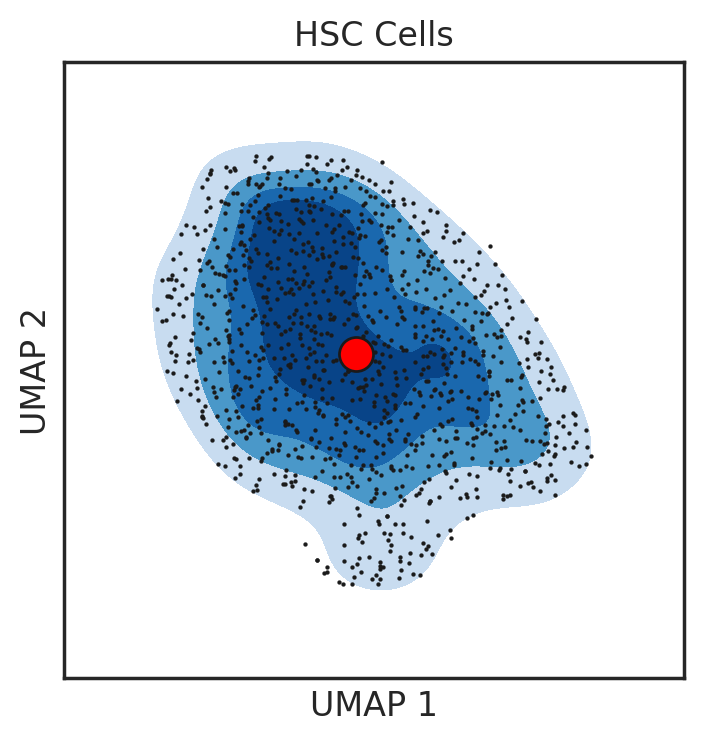

In [7]:
# create the true mean vector based on the embedding space
hsc_mean = hsc_adata.X.mean(axis=0)
hsc_mean = hsc_mean.reshape(-1, 1)
print(f"{hsc_mean.shape=}")


# plot the cells around the mean
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# Add Contour Plot
x = hsc_adata.obsm['X_umap'][:, 0]
y = hsc_adata.obsm['X_umap'][:, 1]

# Create a grid for density estimation
x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                             np.linspace(y.min(), y.max(), 100))

# Calculate kernel density estimation and plot
z = sns.kdeplot(x=x, y=y, levels=5, thresh=0.1, cmap="Blues", fill=True)

# Set zorder to place the contour behind the scatter points
z.collections[0].set_zorder(0) 

# Plot scatterplot on top of the contour
sns.scatterplot(
    data=hsc_adata.obs,
    x=hsc_adata.obsm['X_umap'][:, 0],
    y=hsc_adata.obsm['X_umap'][:, 1],
    color='k',
    ec='k',
    s=2,
    zorder=1
)

# Plot the mean point
sns.scatterplot(
    x=[hsc_adata.obsm['X_umap'][:, 0].mean()],
    y=[hsc_adata.obsm['X_umap'][:, 1].mean()],
    color='red',
    ec='k',
    s=150,
    zorder=2  # Set zorder to place the mean point on top
)

# Add plot details
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title('HSC Cells')

# Display the plot
plt.show()

# Plot the Fibroblast data

In [8]:
fb_df = df[df['standardized_cell_type'] == 'Fibroblast'].reset_index(drop=True)
fb_data = Dataset.from_pandas(fb_df)

reload(gtu)
torch.cuda.empty_cache()
fb_embs = gtu.extract_embedding_in_mem(
    model, 
    fb_data, 
    layer_to_quant=-1,
    forward_batch_size=100,
)
print(f"{fb_embs.shape=}")

# translate into an anndata object and plot
fb_adata = gtu.embedding_to_adata(fb_embs)
fb_adata.obs = fb_df.copy()

sc.tl.pca(fb_adata, n_comps=25)
sc.pp.neighbors(fb_adata, n_neighbors=200)
sc.tl.umap(fb_adata, 
           min_dist=0.75,
          )

fb_adata

100%|██████████| 9/9 [00:32<00:00,  3.65s/it]


fb_embs.shape=(861, 512)


AnnData object with n_obs × n_vars = 861 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__', 'cell_id'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

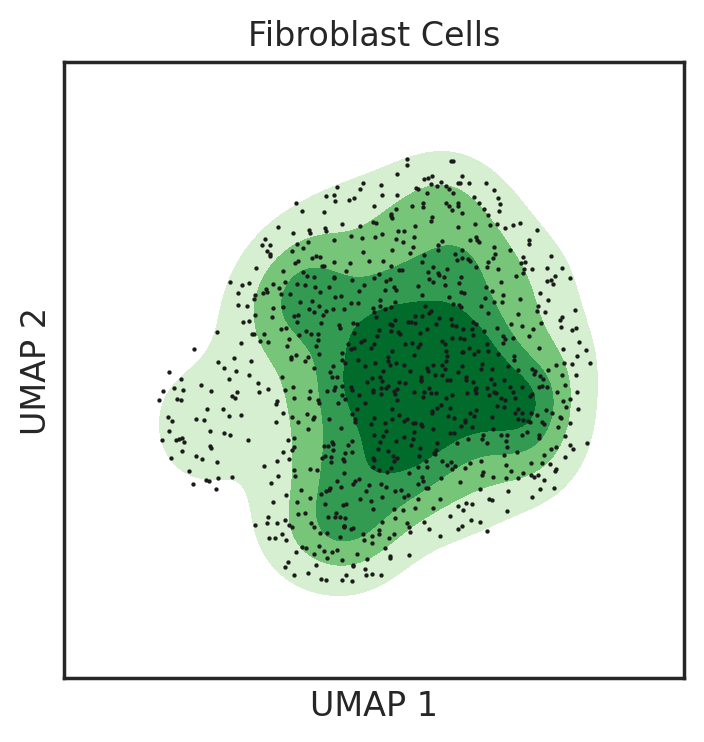

In [9]:
# plot the cells around the mean
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# Add Contour Plot
x = fb_adata.obsm['X_umap'][:, 0]
y = fb_adata.obsm['X_umap'][:, 1]

# Create a grid for density estimation
x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                             np.linspace(y.min(), y.max(), 100))

# Calculate kernel density estimation and plot
z = sns.kdeplot(x=x, y=y, levels=5, thresh=0.1, cmap="Greens", fill=True)

# Set zorder to place the contour behind the scatter points
z.collections[0].set_zorder(0) 

# Plot scatterplot on top of the contour
sns.scatterplot(
    data=fb_adata.obs,
    x=fb_adata.obsm['X_umap'][:, 0],
    y=fb_adata.obsm['X_umap'][:, 1],
    color='k',
    ec='k',
    s=2,
    zorder=1
)


# Add plot details
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title('Fibroblast Cells')

# Display the plot
plt.show()

# Plot them together

In [5]:
reload(gtu)
torch.cuda.empty_cache()
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)
print(f"{embs.shape=}")

# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = df.copy()

sc.tl.pca(adata, n_comps=25)
sc.pp.neighbors(adata, n_neighbors=200)
sc.tl.umap(adata, 
           min_dist=0.75,
          )
adata

100%|██████████| 200/200 [01:23<00:00,  2.38it/s]


embs.shape=(2000, 512)


AnnData object with n_obs × n_vars = 2000 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__', 'cell_id'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

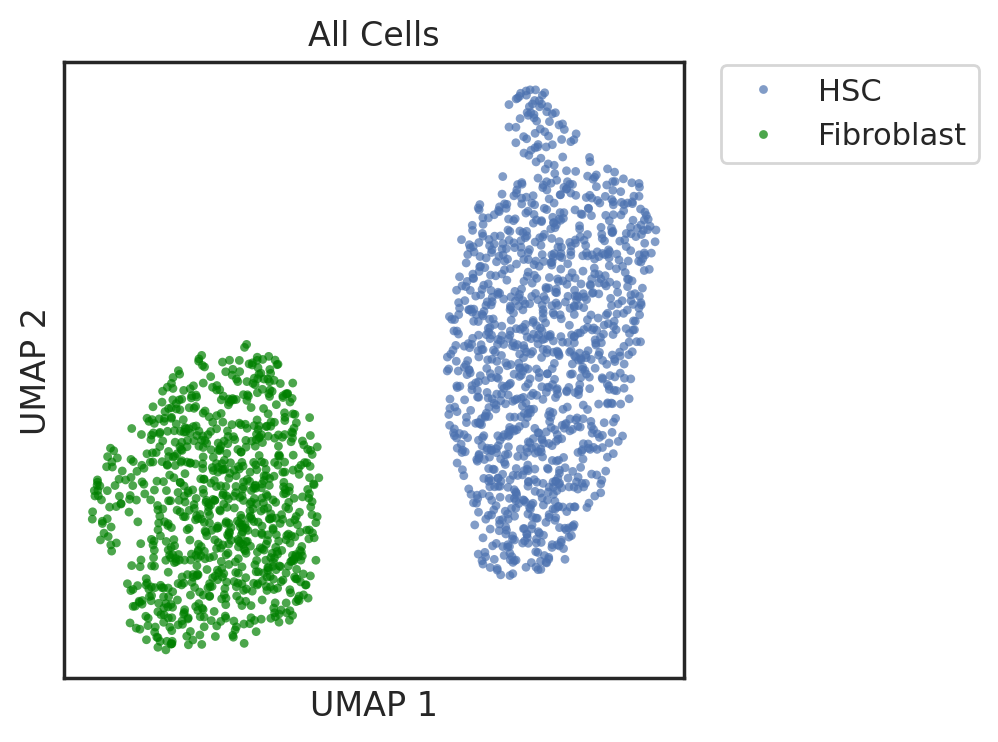

In [11]:
sns.scatterplot(
    data=adata.obs,
    x=adata.obsm['X_umap'][:, 0],
    y=adata.obsm['X_umap'][:, 1],
    hue='standardized_cell_type',
    ec='none',
    palette=['C0', 'Green'],
    s=10,
    alpha=0.7,
    zorder=1
)

# Add plot details
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title('All Cells')

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper right',
    bbox_to_anchor=(1.5, 1.02),
)

# pre-compute cell-cell distances

In [12]:
def make_colorbar(cmap='viridis', 
                  width=0.2,
                  height=2.5, 
                  title='', 
                  orientation='vertical', 
                  tick_labels=[0, 1]):
    """
    Creates and displays a standalone colorbar using Matplotlib.

    Args:
        cmap (str or matplotlib.colors.Colormap): The colormap to use for the colorbar.
        width (float): The width of the colorbar figure in inches.
        height (float): The height of the colorbar figure in inches.
        title (str): The title to display above or next to the colorbar.
        orientation (str): The orientation of the colorbar ('vertical' or 'horizontal').
        tick_labels (list of str): The labels to display at each tick on the colorbar.

    Returns:
        None: This function displays the colorbar directly using Matplotlib.

    Raises:
        ValueError: If the `orientation` is not 'vertical' or 'horizontal'.
    """
    
    a = np.array([[0, 1]])  # Dummy data for the image
    plt.figure(figsize=(width, height))
    img = plt.imshow(a, cmap=cmap)
    plt.gca().set_visible(False)  # Hide the axes of the image
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])  # Define the colorbar position

    ticks = np.linspace(0, 1, len(tick_labels)) 
    cbar = plt.colorbar(
        orientation=orientation,
        cax=cax,
        label=title,
        ticks=ticks
    )

    if orientation == 'vertical':
        cbar.ax.set_yticklabels(tick_labels)
    elif orientation == 'horizontal':
        cbar.ax.set_xticklabels(tick_labels)

X.shape=(2000, 512)
D.shape=(2000, 2000)


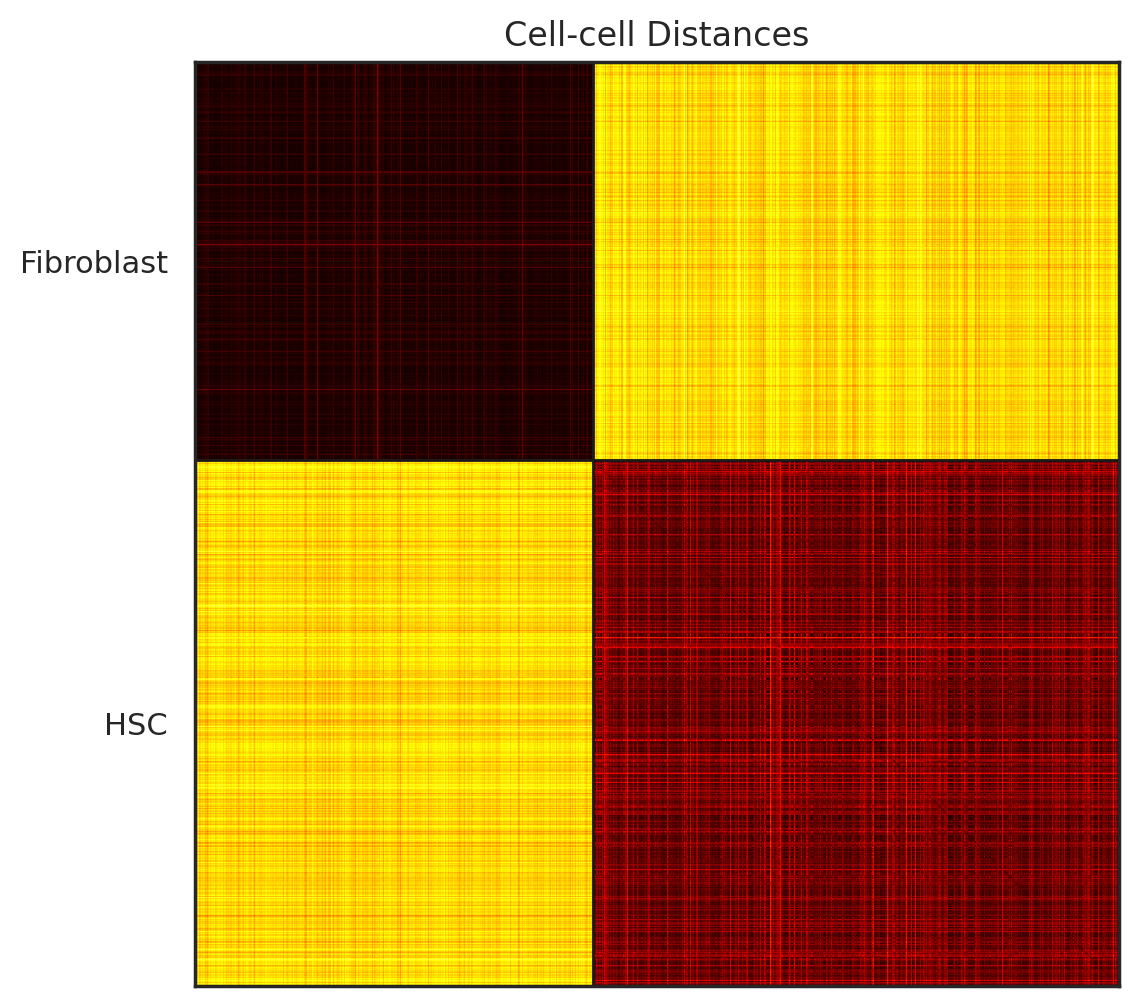

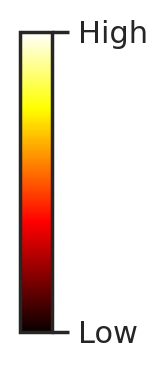

In [13]:
# sort by cell-type

"""
In this block I compute the consine distance in embedding space between all fibroblasts and all hsc cells
"""

sorted_cells = adata.obs.sort_values(by='standardized_cell_type')
change_indices = np.argwhere(sorted_cells['standardized_cell_type'] != sorted_cells['standardized_cell_type'].shift(1))
change_indices = np.ravel(change_indices)
X = adata[sorted_cells.index, :].X
print(f"{X.shape=}")

metric = 'cosine'
cmap = 'hot'
D = squareform(pdist(X, metric=metric))
print(f"{D.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6
plt.imshow(D, cmap=cmap)

# add dividing lines
for pos in change_indices[1:]:
    plt.axvline(x=pos, c='k', lw=1)
    plt.axhline(y=pos, c='k', lw=1)
    
# label the blocks
all_indices = list(change_indices) + [len(X)]
midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
plt.yticks(midpoints, sorted_cells['standardized_cell_type'].unique())

plt.title('Cell-cell Distances')
plt.xticks([])

make_colorbar(cmap=cmap, tick_labels=['Low', 'High'])

# Visualize the variability

hsc_dists.shape=(1147, 1147)


Text(0.5, 1.0, 'HSC-HSC Distances')

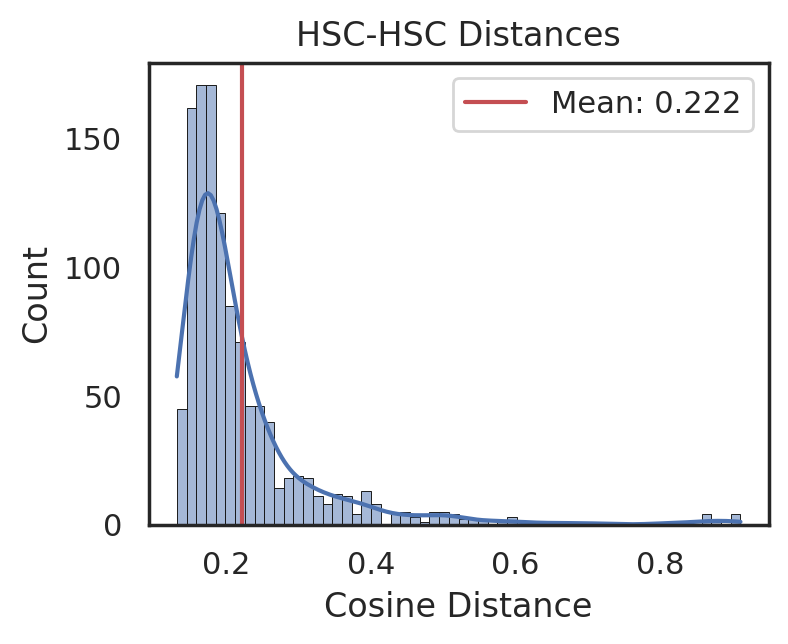

In [14]:
""" Compute the hsc-hsc distances """
hsc_dists = D[853:2000, 853:2000]
print(f"{hsc_dists.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    x=hsc_dists.mean(axis=1),
    ec='k',
    kde=True,
    color='C0',
)

# add mean distance
x = hsc_dists.mean(axis=1).mean()
plt.axvline(x=x, c='r', label=f"Mean: {x:.3f}")
plt.legend()

plt.xlabel('Cosine Distance')
plt.title('HSC-HSC Distances')

fb_dists.shape=(853, 853)


Text(0.5, 1.0, 'FB-FB Distances')

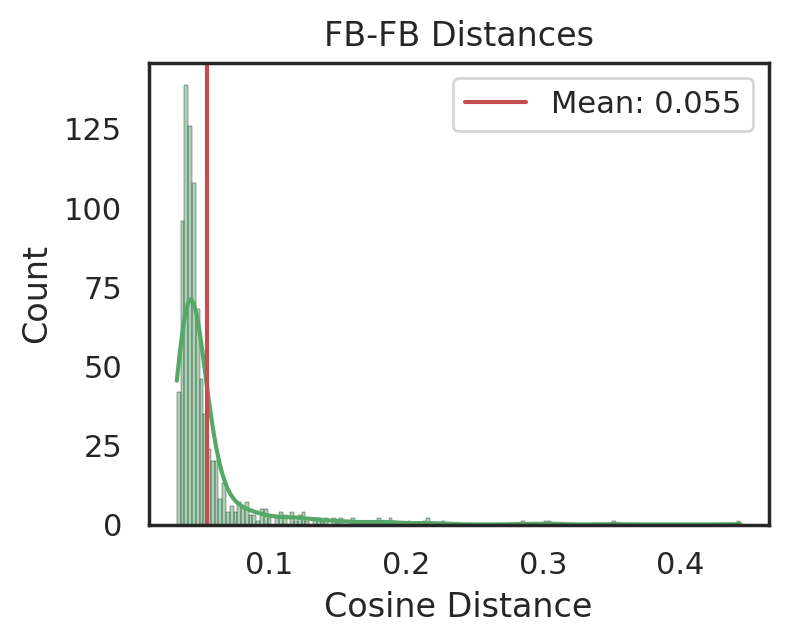

In [15]:
""" Compute the fibroblast-fibroblast distances """
fb_dists = D[0:853, 0:853]
print(f"{fb_dists.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    x=fb_dists.mean(axis=1),
    ec='k',
    kde=True,
    color='C2',
)

# add mean distance
x = fb_dists.mean(axis=1).mean()
plt.axvline(x=x, c='r', label=f"Mean: {x:.3f}")
plt.legend()

plt.xlabel('Cosine Distance')
plt.title('FB-FB Distances')

fb_hsc_dists.shape=(853, 1147)


Text(0.5, 1.0, 'FB-HSC Distances')

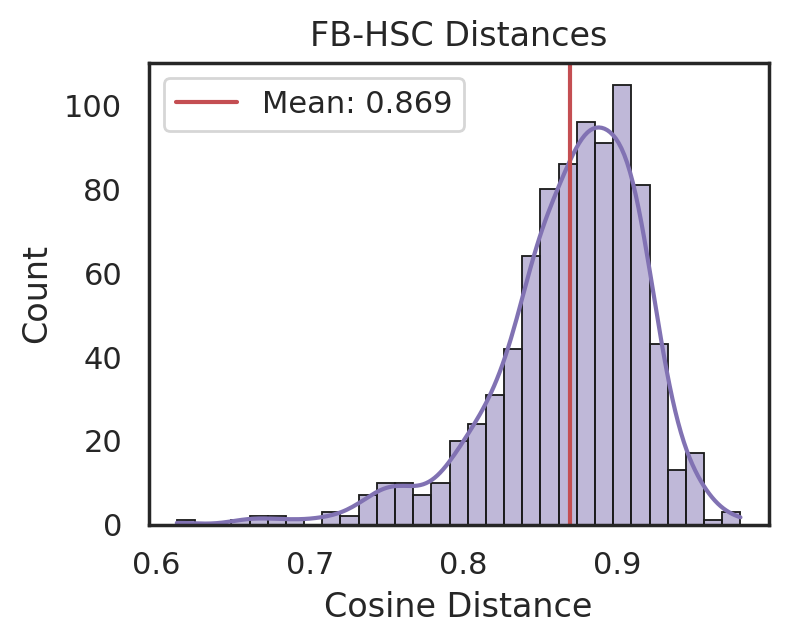

In [16]:
""" Compute the fibroblast-hsc distances """
fb_hsc_dists = D[0:853, 853:2000]
print(f"{fb_hsc_dists.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    x=fb_hsc_dists.mean(axis=1),
    ec='k',
    kde=True,
    color='C4',
)

# add mean distance
x = fb_hsc_dists.mean(axis=1).mean()
plt.axvline(x=x, c='r', label=f"Mean: {x:.3f}")
plt.legend()

plt.xlabel('Cosine Distance')
plt.title('FB-HSC Distances')

# Pertrubations

In [6]:
gene_list = [
    'GATA2', 
    'GFI1B', 
    'FOS', 
    'STAT5A',
    'REL',
    'FOSB',
    'IKZF1',
    'RUNX3',
    'MEF2C',
    'ETV6',
]

genes = token_df[token_df['gene_name'].isin(gene_list)]
tf_map = dict(zip(genes['token_id'].values, genes['gene_name'].values))

genes

gene_id  token_id gene_name  nonzero_median  gene_version  \
404    ENSG00000020633       404     RUNX3        3.195369          19.0   
1532   ENSG00000081189      1532     MEF2C        7.818396          16.0   
5675   ENSG00000125740      5675      FOSB        5.344128          14.0   
5806   ENSG00000126561      5806    STAT5A        2.177263          18.0   
7725   ENSG00000139083      7725      ETV6        3.312123          11.0   
10804  ENSG00000162924     10804       REL        3.891583          16.0   
11599  ENSG00000165702     11599     GFI1B        2.131079          15.0   
12698  ENSG00000170345     12698       FOS       16.001316          10.0   
14409  ENSG00000179348     14409     GATA2        2.523616          13.0   
15641  ENSG00000185811     15641     IKZF1        3.329544          21.0   

         gene_biotype Chromosome        Start          End  scenic_tf  
404    protein_coding          1   24899510.0   24965121.0       True  
1532   protein_coding          5   88717116.0   88904257.0       True  
5675   protein_coding         19   45467994.0   45475179.0       True  
5806   protein_coding         17   42287546.0   42311943.0       True  
7725   protein_coding         12   11649673.0   11895377.0       True  
10804  protein_coding          2   60881490.0   60931612.0       True  
11599  protein_coding          9  132943999.0  132991687.0       True  
12698  protein_coding         14   75278825.0   75282230.0       True  
14409  protein_coding          3  128479426.0  128493201.0       True  
15641  protein_coding          7   50304067.0   50405101.0       True

# Set up the inputs

In [7]:
# compute all possible combinations of 5 TFs,
n_tf = 5
inputs = list(combinations(genes['token_id'], n_tf))
print(f'Number of recipes: {len(inputs)}')

def map_tfs(tokens):
    return list(map(tf_map.get, tokens))

print(inputs[0])
print(map_tfs(inputs[0]))

Number of recipes: 252
(404, 1532, 5675, 5806, 7725)
['RUNX3', 'MEF2C', 'FOSB', 'STAT5A', 'ETV6']


In [8]:
def add_perturbations_to_cell(cell_tokens, perturbation_tokens):
    """
    Modifies a list of cell tokens by adding perturbation tokens and padding.

    Args:
        cell_tokens (list): A list of integers representing gene tokens.
        perturbation_tokens (list): A list of integers representing perturbation tokens.

    Returns:
        list: A new list of tokens with perturbations added, existing perturbations removed,
             and truncated/padded to the original length.
    """

    original_length = len(cell_tokens)

    # Remove existing perturbation tokens from the cell
    cell_tokens = [token for token in cell_tokens if token not in perturbation_tokens]

    # Add perturbations, then slice or pad to match original length
    final_tokens = (perturbation_tokens + cell_tokens)[:original_length]  # Slice if too long
    final_tokens += [0] * (original_length - len(final_tokens))            # Pad if too short

    return final_tokens


# test
test_cell = df.head(1)['input_ids'].values[0]
perturbed = add_perturbations_to_cell(test_cell, list(inputs[0]))

print(test_cell[:10])
print(perturbed[:10])

[14577  3187 17163  1142  7725 10265  9855  3659  9651  9408]
[404, 1532, 5675, 5806, 7725, 14577, 3187, 17163, 1142, 10265]


In [20]:
# set up some perturbations
sample_size = 10

raw_cells = fb_df.sample(sample_size).reset_index(drop=True)
print(f"{raw_cells.shape=}")
raw_cells['recipe'] = 'raw'
raw_cells['type'] = 'initial'

hsc_sample = hsc_df.sample(sample_size).reset_index(drop=True)
hsc_sample['recipe'] = 'hsc'
hsc_sample['type'] = 'target'

reprogramming_df = [
    raw_cells,
    hsc_sample,
]

for i, tfs in enumerate(inputs):
    
    if i % 25 == 0:
        print(f"Pertubation {i}/{len(inputs)}...")
    
    # make the dataframe easily useable
    perturb = raw_cells.copy()
    recipe = ";".join(map_tfs(tfs))
    perturb['recipe'] = recipe
    perturb['type'] = 'reprogrammed'
    
    # do the actual perturbation
    perturb['input_ids'] = perturb['input_ids'].apply(lambda x: add_perturbations_to_cell(x, list(tfs)))
    
    # store the updated data
    reprogramming_df.append(perturb)
    
reprogramming_df = pd.concat(reprogramming_df)
reprogramming_df = reprogramming_df.reset_index(drop=True)
print(f"{reprogramming_df.shape=}")
reprogramming_df.sample(10)

raw_cells.shape=(10, 9)
Pertubation 0/252...
Pertubation 25/252...
Pertubation 50/252...
Pertubation 75/252...
Pertubation 100/252...
Pertubation 125/252...
Pertubation 150/252...
Pertubation 175/252...
Pertubation 200/252...
Pertubation 225/252...
Pertubation 250/252...
reprogramming_df.shape=(2540, 11)


input_ids    cell_type  \
1371  [1532, 5675, 5806, 11599, 12698, 9009, 16916, ...   fibroblast   
287   [404, 1532, 5806, 10804, 11599, 16916, 454, 62...  Fibroblasts   
941   [404, 5806, 7725, 10804, 12698, 9009, 16916, 1...   fibroblast   
1687  [1532, 5806, 7725, 11599, 14409, 16916, 454, 6...  Fibroblasts   
19    [10265, 7725, 3562, 3980, 24400, 17571, 4252, ...          HSC   
567   [404, 1532, 11599, 14409, 15641, 16916, 454, 6...  Fibroblasts   
1023  [404, 5806, 7725, 14409, 15641, 9227, 18367, 1...  Fibroblasts   
13    [9408, 3187, 14577, 14751, 111, 583, 1329, 365...          HSC   
2449  [5806, 10804, 11599, 12698, 15641, 1155, 9009,...  Fibroblasts   
2215  [5675, 7725, 10804, 12698, 14409, 16916, 12119...   fibroblast   

                 dataset  length       ignore standardized_cell_type  \
1371      TS_Vasculature    2048   fibroblast             Fibroblast   
287               TS_Fat    2048  Fibroblasts             Fibroblast   
941       TS_Vasculature    2048   fibroblast             Fibroblast   
1687              TS_Fat    2048  Fibroblasts             Fibroblast   
19    weng_young1_all_t2    1001          HSC                    HSC   
567               TS_Fat    2048  Fibroblasts             Fibroblast   
1023              TS_Fat    1500  Fibroblasts             Fibroblast   
13       weng_young2_HSC    1653          HSC                    HSC   
2449              TS_Fat    1452  Fibroblasts             Fibroblast   
2215      TS_Vasculature    2048   fibroblast             Fibroblast   

           broad_type  __index_level_0__    cell_id  \
1371       fibroblast             111921   cell_616   
287        fibroblast             161019  cell_1023   
941        fibroblast             111921   cell_616   
1687       fibroblast             161019  cell_1023   
19    stem/progenitor              73310   cell_479   
567        fibroblast             161019  cell_1023   
1023       fibroblast             166861  cell_1635   
13    stem/progenitor             237000   cell_184   
2449       fibroblast             153878  cell_1264   
2215       fibroblast             117300  cell_1860   

                             recipe          type  
1371    MEF2C;FOSB;STAT5A;GFI1B;FOS  reprogrammed  
287    RUNX3;MEF2C;STAT5A;REL;GFI1B  reprogrammed  
941       RUNX3;STAT5A;ETV6;REL;FOS  reprogrammed  
1687  MEF2C;STAT5A;ETV6;GFI1B;GATA2  reprogrammed  
19                              hsc        target  
567   RUNX3;MEF2C;GFI1B;GATA2;IKZF1  reprogrammed  
1023  RUNX3;STAT5A;ETV6;GATA2;IKZF1  reprogrammed  
13                              hsc        target  
2449     STAT5A;REL;GFI1B;FOS;IKZF1  reprogrammed  
2215        FOSB;ETV6;REL;FOS;GATA2  reprogrammed

# Perturbation Embedding

In [9]:
reload(gtu)
torch.cuda.empty_cache()

reprogramming_data = Dataset.from_pandas(reprogramming_df)

reprogramming_embs = gtu.extract_embedding_in_mem(
    model, 
    reprogramming_data, 
    layer_to_quant=-1,
    forward_batch_size=100,
)
print(f"{reprogramming_embs.shape=}")

# translate into an anndata object and plot
reprogramming_adata = gtu.embedding_to_adata(reprogramming_embs)
reprogramming_adata.obs = reprogramming_df.copy()

sc.tl.pca(reprogramming_adata, n_comps=25)
sc.pp.neighbors(reprogramming_adata, n_neighbors=200)
sc.tl.umap(reprogramming_adata, 
           min_dist=0.75,
          )

reprogramming_adata

NameError: name 'reprogramming_df' is not defined

In [ ]:

# Create a new AnnData object to modify
mod_reprogramming_adata = reprogramming_adata.copy()

# Extract the rows with 'type' == 'raw' and 'type' == 'target'
raw_rows = mod_reprogramming_adata[mod_reprogramming_adata.obs['type'] == 'initial']
target_rows = mod_reprogramming_adata[mod_reprogramming_adata.obs['type'] == 'target']
reprog_rows = mod_reprogramming_adata[mod_reprogramming_adata.obs['type'] == 'reprogrammed']

# Copy these rows 50 times
raw_rows_repeated = raw_rows.concatenate([raw_rows] * 50)
target_rows_repeated = target_rows.concatenate([target_rows] * 50)


# Append the copied rows to the original AnnData object
mod_reprogramming_adata = mod_reprogramming_adata.concatenate(raw_rows_repeated, reprog_rows, target_rows_repeated )

# Confirm the changes
print(f"Original shape: {reprogramming_adata.shape}")
print(f"Modified shape: {mod_reprogramming_adata.shape}")


In [23]:
mod_reprogramming_adata.obs['type'].value_counts()

type
reprogrammed    5040
initial          520
target           520
Name: count, dtype: int64

# Plot

X.shape=(6080, 512)
D.shape=(6080, 6080)


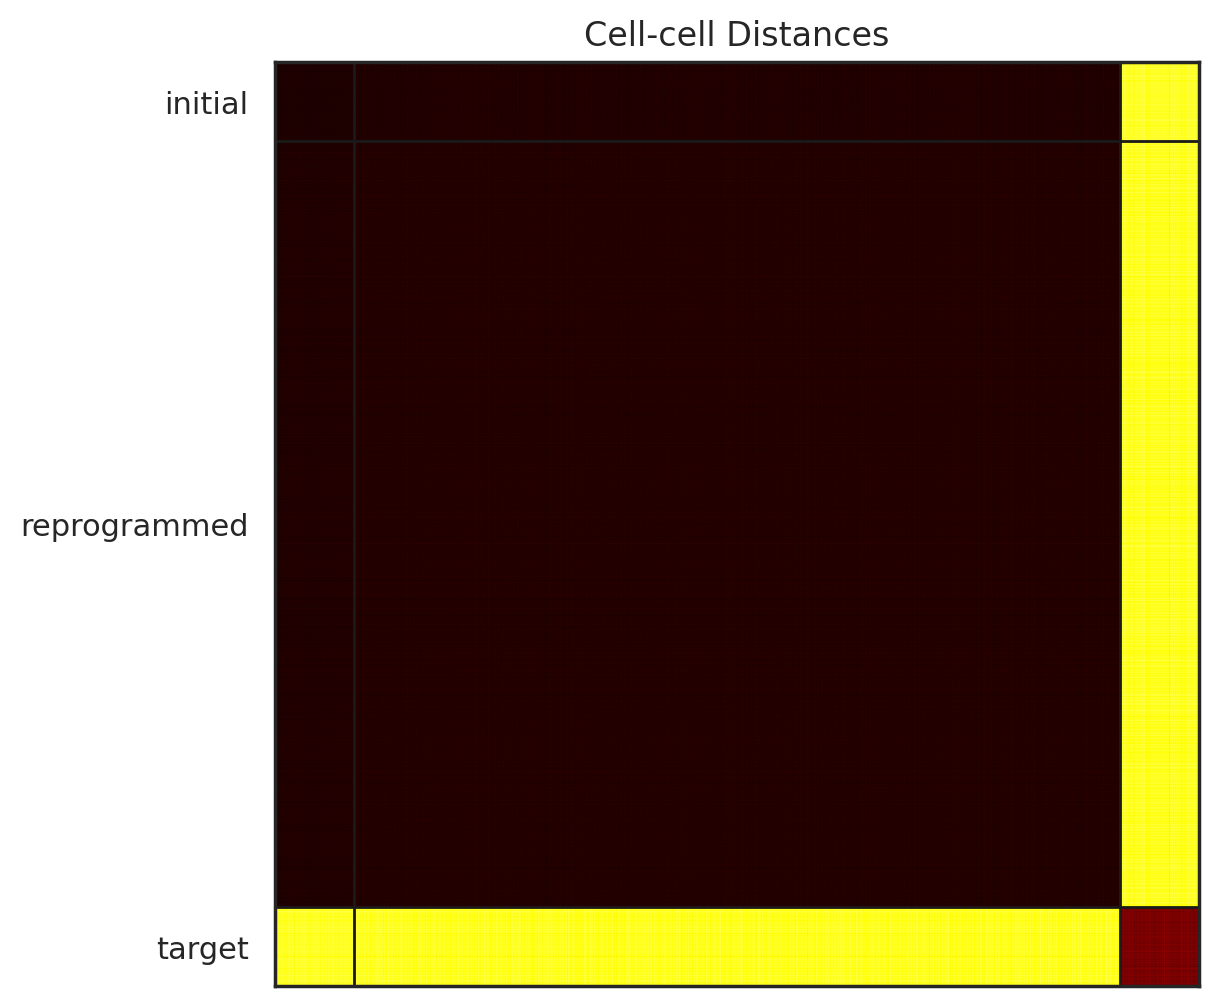

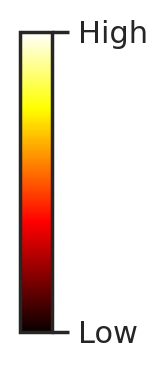

In [24]:
# # # # Nat's plot edition

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial.distance import pdist, squareform

# # Step 1: Sort cells by 'standardized_cell_type'
# sorted_cells = reprogramming_adata.obs.sort_values(by='standardized_cell_type')
# change_indices = np.argwhere(sorted_cells['standardized_cell_type'] != sorted_cells['standardized_cell_type'].shift(1))
# change_indices = np.ravel(change_indices)
# X = reprogramming_adata[sorted_cells.index, :].X
# print(f"{X.shape=}")

# # Step 2: Compute cosine distances
# metric = 'cosine'
# cmap = 'hot'
# D = squareform(pdist(X, metric=metric))
# print(f"{D.shape=}")

# # Step 3: Plot the distance matrix
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 6, 6
# fig, ax = plt.subplots()
# im = ax.imshow(D, cmap=cmap)

# # Add dividing lines
# for pos in change_indices[1:]:
#     ax.axvline(x=pos, c='k', lw=1)
#     ax.axhline(y=pos, c='k', lw=1)

# # Label the blocks
# all_indices = list(change_indices) + [len(X)]
# midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
# ax.set_yticks(midpoints)
# ax.set_yticklabels(sorted_cells['standardized_cell_type'].unique())

# ax.set_title('Cell-cell Distances')
# ax.set_xticks([])

# # Step 4: Add the colorbar
# def make_colorbar(im, tick_labels):
#     cbar = plt.colorbar(im, ax=ax, ticks=[im.get_clim()[0], im.get_clim()[1]])
#     cbar.ax.set_yticklabels(tick_labels)

# make_colorbar(im, tick_labels=['Low', 'High'])

# plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial.distance import pdist, squareform

# # Step 1: Sort cells by 'standardized_cell_type'
# sorted_cells = reprogramming_adata.obs.sort_values(by='standardized_cell_type')
# change_indices = np.argwhere(sorted_cells['standardized_cell_type'] != sorted_cells['standardized_cell_type'].shift(1))
# change_indices = np.ravel(change_indices)
# X = reprogramming_adata[sorted_cells.index, :].X
# print(f"{X.shape=}")

# # Step 2: Compute cosine distances
# metric = 'cosine'
# cmap = 'hot'
# D = squareform(pdist(X, metric=metric))
# print(f"{D.shape=}")

# # Identify initial and target categories
# initial_category = 'initial'  # Replace with the actual name of the initial category
# target_category = 'target'    # Replace with the actual name of the target category

# initial_indices = sorted_cells.index[sorted_cells['standardized_cell_type'] == initial_category].tolist()
# target_indices = sorted_cells.index[sorted_cells['standardized_cell_type'] == target_category].tolist()

# # Adjust the positions of the initial and target categories
# initial_size = len(initial_indices)
# target_size = len(target_indices)
# change_indices = [0] + [initial_size] + [initial_size + target_size] + list(change_indices + initial_size + target_size)

# # Step 3: Plot the distance matrix
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 6, 6
# fig, ax = plt.subplots()
# im = ax.imshow(D, cmap=cmap)

# # Add dividing lines
# for pos in change_indices[1:]:
#     ax.axvline(x=pos, c='k', lw=1)
#     ax.axhline(y=pos, c='k', lw=1)

# # Label the blocks
# all_indices = list(change_indices) + [len(X)]
# midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
# ax.set_yticks(midpoints)
# ax.set_yticklabels(sorted_cells['standardized_cell_type'].unique())

# ax.set_title('Cell-cell Distances')
# ax.set_xticks([])

# # Step 4: Add the colorbar
# def make_colorbar(im, tick_labels):
#     cbar = plt.colorbar(im, ax=ax, ticks=[im.get_clim()[0], im.get_clim()[1]])
#     cbar.ax.set_yticklabels(tick_labels)

# make_colorbar(im, tick_labels=['Low', 'High'])

# plt.show()


#######################################
#good one

sorted_cells = mod_reprogramming_adata.obs.sort_values(by='type')
change_indices = np.argwhere(sorted_cells['type'] != sorted_cells['type'].shift(1))
change_indices = np.ravel(change_indices)
X = mod_reprogramming_adata[sorted_cells.index, :].X
print(f"{X.shape=}")

metric = 'cosine'
cmap = 'hot'
D = squareform(pdist(X, metric=metric))
print(f"{D.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6
plt.imshow(D, cmap=cmap)

# add dividing lines
for pos in change_indices[1:]:
    plt.axvline(x=pos, c='k', lw=1)
    plt.axhline(y=pos, c='k', lw=1)
    
# label the blocks
all_indices = list(change_indices) + [len(X)]
midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
plt.yticks(midpoints, sorted_cells['type'].unique())

plt.title('Cell-cell Distances')
plt.xticks([])

make_colorbar(cmap=cmap, tick_labels=['Low', 'High'])



#####################################

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial.distance import pdist, squareform

# sorted_cells = mod_reprogramming_adata.obs.sort_values(by='type')
# change_indices = np.argwhere(sorted_cells['type'] != sorted_cells['type'].shift(1))
# change_indices = np.ravel(change_indices)
# X = mod_reprogramming_adata[sorted_cells.index, :].X
# print(f"{X.shape=}")

# metric = 'cosine'
# cmap = 'hot'
# D = squareform(pdist(X, metric=metric))
# print(f"{D.shape=}")

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 6, 6
# plt.imshow(D, cmap=cmap)

# # add dividing lines
# for pos in change_indices[1:]:
#     plt.axvline(x=pos, c='k', lw=1)
#     plt.axhline(y=pos, c='k', lw=1)
    
# # label the blocks
# all_indices = list(change_indices) + [len(X)]
# midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
# plt.yticks(midpoints, sorted_cells['type'].unique(), fontsize=20)  # Increase font size

# plt.title('Cell-cell Distances')
# plt.xticks([])

# make_colorbar(cmap=cmap, tick_labels=['Low', 'High'])

# plt.show()




# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial.distance import pdist, squareform

# # Step 1: Sort cells by 'standardized_cell_type'
# sorted_cells = reprogramming_adata.obs.sort_values(by='standardized_cell_type')
# change_indices = np.argwhere(sorted_cells['standardized_cell_type'] != sorted_cells['type'].shift(1))
# change_indices = np.ravel(change_indices)
# X = reprogramming_adata[sorted_cells.index, :].X
# print(f"{X.shape=}")

# # Step 2: Compute cosine distances
# metric = 'cosine'
# cmap = 'hot'
# D = squareform(pdist(X, metric=metric))
# print(f"{D.shape=}")

# # Step 3: Plot the distance matrix
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 6, 6
# plt.imshow(D, cmap=cmap)

# # Add dividing lines
# for pos in change_indices[1:]:
#     plt.axvline(x=pos, c='k', lw=1)
#     plt.axhline(y=pos, c='k', lw=1)

# # Label the blocks
# all_indices = list(change_indices) + [len(X)]
# midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
# plt.yticks(midpoints, sorted_cells['standardized_cell_type'].unique())

# plt.title('Cell-cell Distances')
# plt.xticks([])

# def make_colorbar(cmap, tick_labels):
#     # Custom function to make a colorbar
#     from matplotlib.colors import Normalize
#     from matplotlib.cm import ScalarMappable

#     norm = Normalize(vmin=0, vmax=1)
#     sm = ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     cbar = plt.colorbar(sm, ticks=[0, 1])
#     cbar.ax.set_yticklabels(tick_labels)

# make_colorbar(cmap=cmap, tick_labels=['Low', 'High'])

# plt.show()


X.shape=(6080, 512)
D.shape=(6080, 6080)


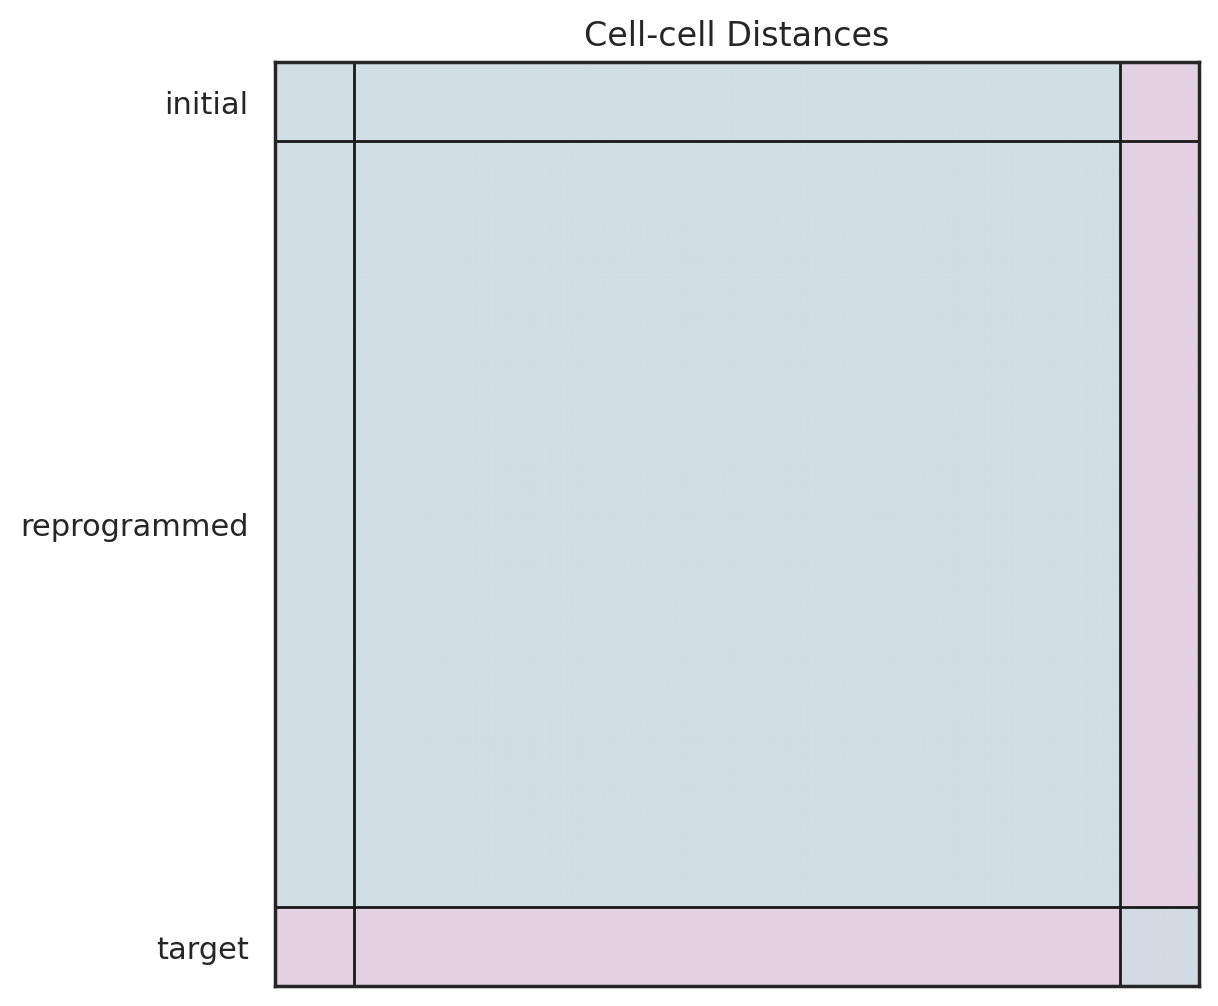

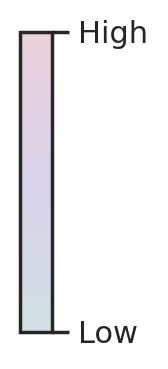

In [36]:
#above plot with a color change.

from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Custom color map
colors = ['#d0e0e3', '#d9d2e9', '#ead1dc']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

sorted_cells = mod_reprogramming_adata.obs.sort_values(by='type')
change_indices = np.argwhere(sorted_cells['type'] != sorted_cells['type'].shift(1))
change_indices = np.ravel(change_indices)
X = mod_reprogramming_adata[sorted_cells.index, :].X
print(f"{X.shape=}")

metric = 'cosine'
D = squareform(pdist(X, metric=metric))
print(f"{D.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6
plt.imshow(D, cmap=cmap)

# add dividing lines
for pos in change_indices[1:]:
    plt.axvline(x=pos, c='k', lw=1)
    plt.axhline(y=pos, c='k', lw=1)
    
# label the blocks
all_indices = list(change_indices) + [len(X)]
midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
plt.yticks(midpoints, sorted_cells['type'].unique())

plt.title('Cell-cell Distances')
plt.xticks([])

make_colorbar(cmap=cmap, tick_labels=['Low', 'High'])


X.shape=(6080, 512)
D.shape=(6080, 6080)


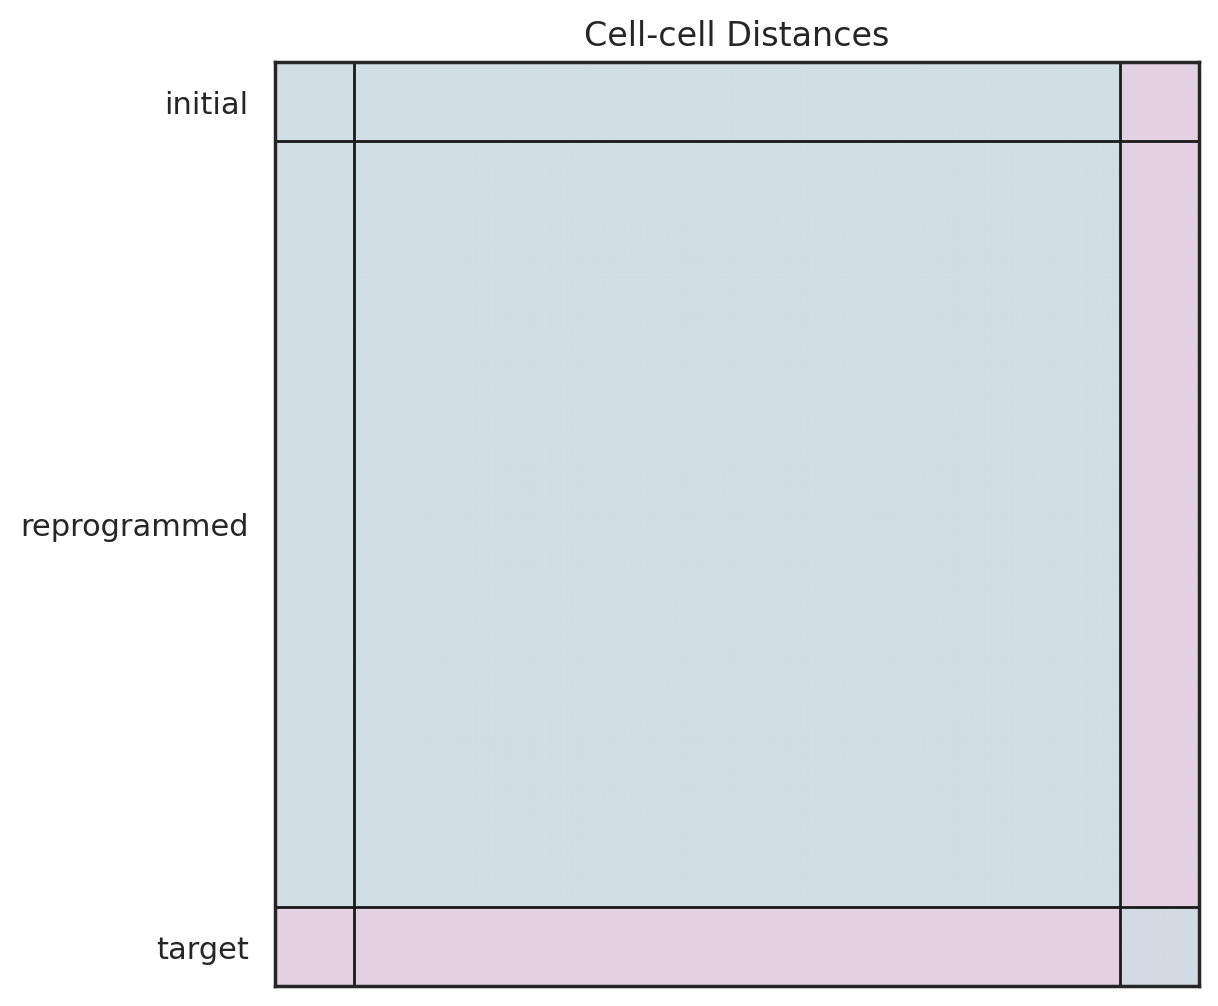

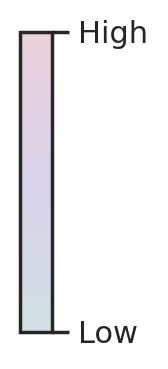

In [37]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Custom color map
colors = ['#d0e0e3', '#d9d2e9', '#ead1dc']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

sorted_cells = mod_reprogramming_adata.obs.sort_values(by='type')
change_indices = np.argwhere(sorted_cells['type'] != sorted_cells['type'].shift(1))
change_indices = np.ravel(change_indices)
X = mod_reprogramming_adata[sorted_cells.index, :].X
print(f"{X.shape=}")

metric = 'cosine'
D = squareform(pdist(X, metric=metric))
print(f"{D.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6
plt.imshow(D, cmap=cmap)

# add dividing lines
for pos in change_indices[1:]:
    plt.axvline(x=pos, c='k', lw=1)
    plt.axhline(y=pos, c='k', lw=1)
    
# label the blocks
all_indices = list(change_indices) + [len(X)]
midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
plt.yticks(midpoints, sorted_cells['type'].unique())

plt.title('Cell-cell Distances')
plt.xticks([])

make_colorbar(cmap=cmap, tick_labels=['Low', 'High'])


X.shape=(6080, 512)
D.shape=(6080, 6080)


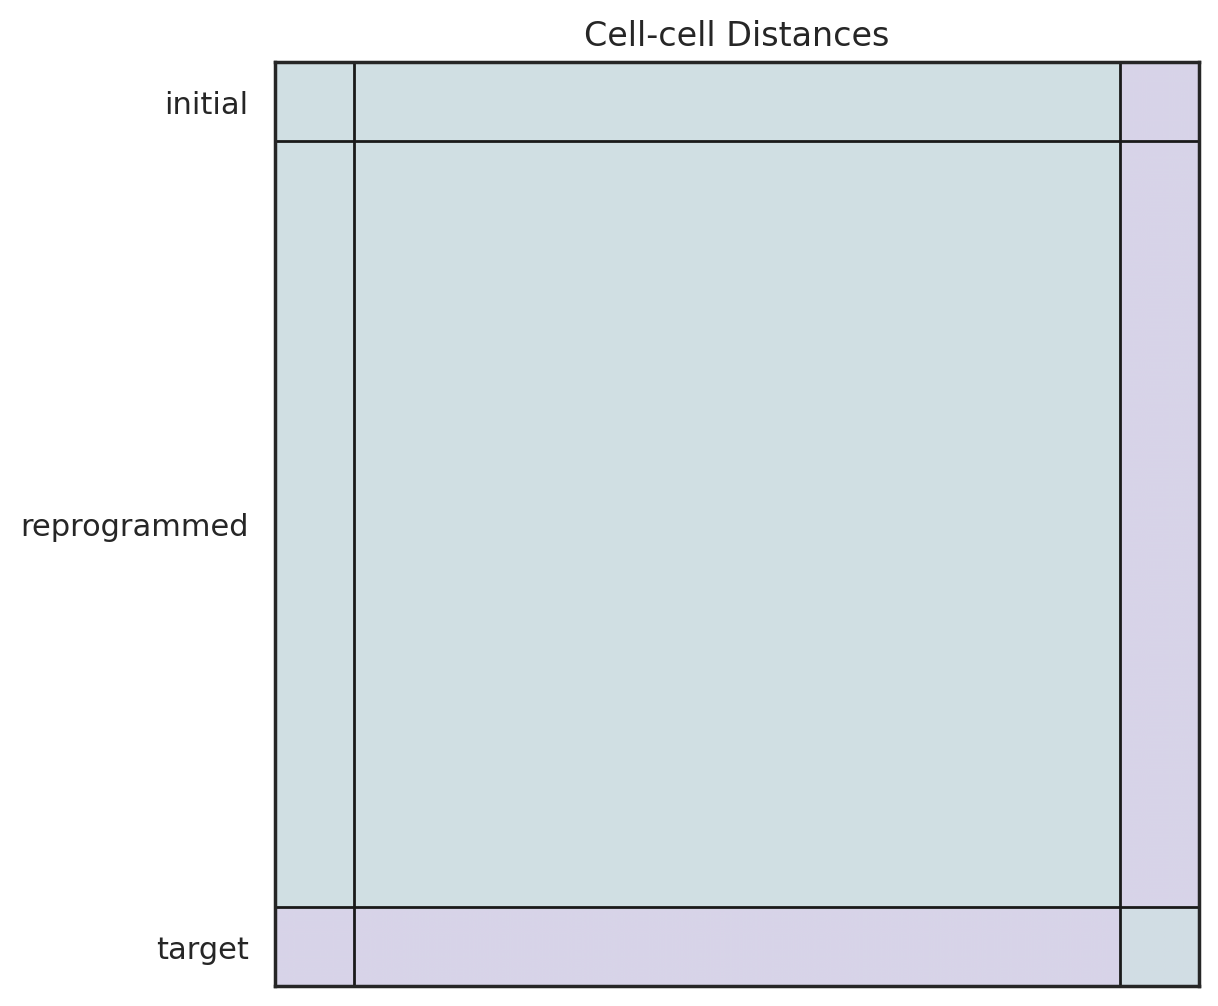

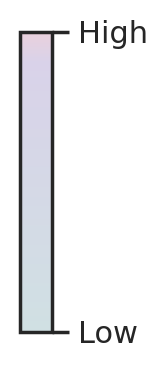

In [43]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Custom color map with more contrast
colors = ['#d0e0e3', '#d9d2e9', '#ead1dc']
positions = [0, 0.9, 1]  # Adjust positions to create more contrast
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

sorted_cells = mod_reprogramming_adata.obs.sort_values(by='type')
change_indices = np.argwhere(sorted_cells['type'] != sorted_cells['type'].shift(1))
change_indices = np.ravel(change_indices)
X = mod_reprogramming_adata[sorted_cells.index, :].X
print(f"{X.shape=}")

metric = 'cosine'
D = squareform(pdist(X, metric=metric))
print(f"{D.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6
plt.imshow(D, cmap=cmap)

# add dividing lines
for pos in change_indices[1:]:
    plt.axvline(x=pos, c='k', lw=1)
    plt.axhline(y=pos, c='k', lw=1)
    
# label the blocks
all_indices = list(change_indices) + [len(X)]
midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
plt.yticks(midpoints, sorted_cells['type'].unique())

plt.title('Cell-cell Distances')
plt.xticks([])

make_colorbar(cmap=cmap, tick_labels=['Low', 'High'])


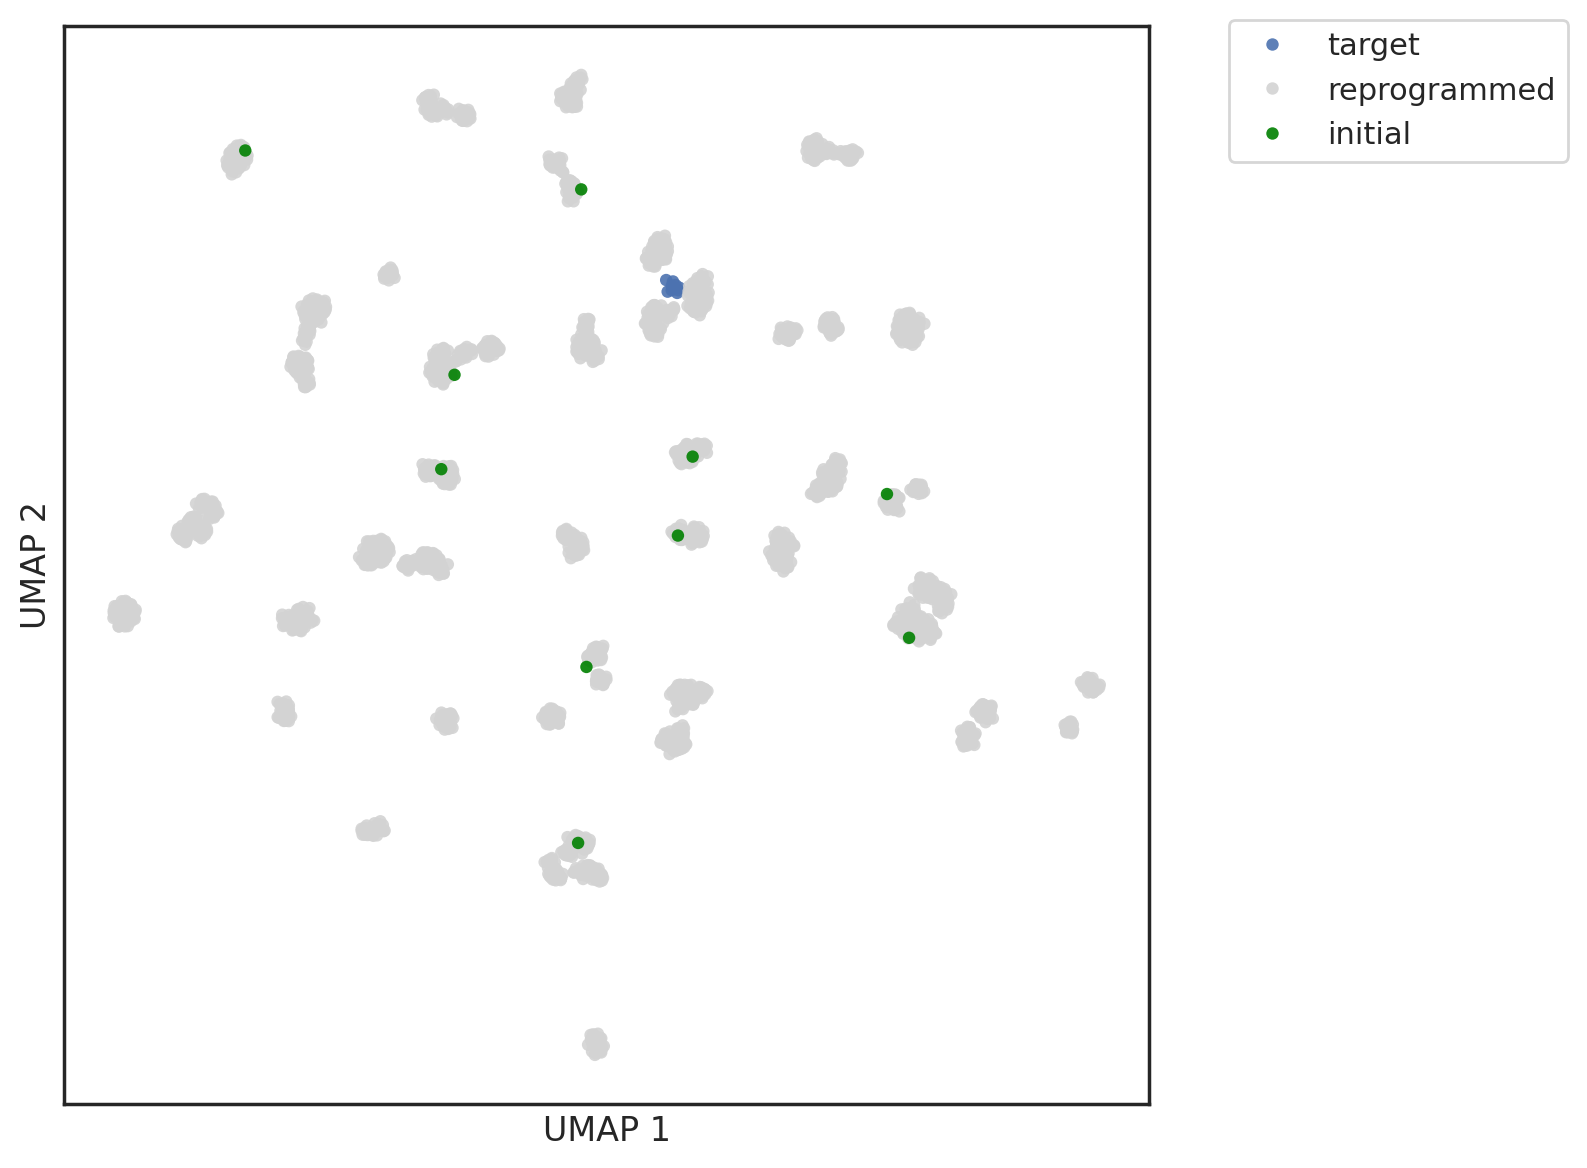

In [25]:
pdf = reprogramming_adata.obs.copy()
pdf['UMAP 1'] = reprogramming_adata.obsm['X_umap'][:, 0]
pdf['UMAP 2'] = reprogramming_adata.obsm['X_umap'][:, 1]

pdf = pdf.sort_values(by='type', ascending=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

sns.scatterplot(
    data=pdf,
    x='UMAP 1',
    y='UMAP 2',
    hue='type',
    ec='none',
    palette=['C0', 'lightgrey', 'green'],
    s=20,
    alpha=0.9,
    zorder=1
)

# # Add plot details
plt.yticks([])
plt.xticks([])
# # plt.title('All Cells')

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper right',
    bbox_to_anchor=(1.4, 1.02),
)

# minimal distance to target

In [135]:
initial = reprogramming_adata.obs[reprogramming_adata.obs['type'] == 'initial']
target = reprogramming_adata.obs[reprogramming_adata.obs['type'] == 'target']
repro = reprogramming_adata.obs[reprogramming_adata.obs['type'] == 'reprogrammed']

# precompute all distances
metric = 'cosine'
D = squareform(pdist(reprogramming_adata.X, metric=metric))
print(f"{D.shape=}")

inital_to_target = D[initial.index, target.index].mean()
print(f"{inital_to_target=:.4f}")

result = []

for i, (recipe, group) in enumerate(repro.groupby('recipe')):
    
    if i % 25 == 0:
        print(f"Recipe {i}/{len(inputs)}...")
    
    # compute group to intial
    recipe_to_initial = D[group.index, initial.index].mean() # average over all cells
    
    # compute group to target
    recipe_to_target = D[group.index, target.index].mean() # average over all cells
    
    row = {
        'recipe' : recipe,
        'recipe_to_initial' : recipe_to_initial,
        'recipe_to_target' : recipe_to_target,
        'recipe_diff' : inital_to_target - recipe_to_target,
    }
    result.append(row)
    
result = pd.DataFrame(result)
result.head(10)

D.shape=(2540, 2540)
inital_to_target=0.8483
Recipe 0/252...
Recipe 25/252...
Recipe 50/252...
Recipe 75/252...
Recipe 100/252...
Recipe 125/252...
Recipe 150/252...
Recipe 175/252...
Recipe 200/252...
Recipe 225/252...
Recipe 250/252...


recipe  recipe_to_initial  recipe_to_target  \
0   ETV6;GFI1B;FOS;GATA2;IKZF1           0.009329          0.833353   
1     ETV6;REL;FOS;GATA2;IKZF1           0.009438          0.833575   
2     ETV6;REL;GFI1B;FOS;GATA2           0.009341          0.834843   
3     ETV6;REL;GFI1B;FOS;IKZF1           0.009124          0.835933   
4   ETV6;REL;GFI1B;GATA2;IKZF1           0.008868          0.842811   
5    FOSB;ETV6;FOS;GATA2;IKZF1           0.006708          0.848447   
6    FOSB;ETV6;GFI1B;FOS;GATA2           0.006727          0.849372   
7    FOSB;ETV6;GFI1B;FOS;IKZF1           0.006615          0.850166   
8  FOSB;ETV6;GFI1B;GATA2;IKZF1           0.009037          0.834482   
9      FOSB;ETV6;REL;FOS;GATA2           0.006779          0.849536   

   recipe_diff  
0     0.014943  
1     0.014722  
2     0.013454  
3     0.012364  
4     0.005485  
5    -0.000151  
6    -0.001076  
7    -0.001870  
8     0.013815  
9    -0.001240

In [137]:
result = result.sort_values(by='recipe_diff', ascending=False)
result.head(15)

recipe  recipe_to_initial  recipe_to_target  \
85    MEF2C;GFI1B;FOS;GATA2;IKZF1           0.009767          0.832377   
100  MEF2C;STAT5A;FOS;GATA2;IKZF1           0.009878          0.832422   
86      MEF2C;REL;FOS;GATA2;IKZF1           0.009838          0.832633   
110     REL;GFI1B;FOS;GATA2;IKZF1           0.009778          0.832854   
247  STAT5A;GFI1B;FOS;GATA2;IKZF1           0.009904          0.832973   
248    STAT5A;REL;FOS;GATA2;IKZF1           0.009947          0.833145   
22   FOSB;STAT5A;ETV6;GATA2;IKZF1           0.009501          0.833217   
0      ETV6;GFI1B;FOS;GATA2;IKZF1           0.009329          0.833353   
1        ETV6;REL;FOS;GATA2;IKZF1           0.009438          0.833575   
101  MEF2C;STAT5A;GFI1B;FOS;GATA2           0.009807          0.833832   
40     MEF2C;ETV6;FOS;GATA2;IKZF1           0.009324          0.833834   
104    MEF2C;STAT5A;REL;FOS;GATA2           0.009850          0.833865   
87      MEF2C;REL;GFI1B;FOS;GATA2           0.009739          0.834013   
237   STAT5A;ETV6;FOS;GATA2;IKZF1           0.009403          0.834343   
8     FOSB;ETV6;GFI1B;GATA2;IKZF1           0.009037          0.834482   

     recipe_diff  
85      0.015920  
100     0.015874  
86      0.015663  
110     0.015442  
247     0.015324  
248     0.015152  
22      0.015079  
0       0.014943  
1       0.014722  
101     0.014464  
40      0.014463  
104     0.014431  
87      0.014284  
237     0.013953  
8       0.013815

In [138]:
result = result.sort_values(by='recipe_to_target', ascending=False)
result.head(15)

recipe  recipe_to_initial  recipe_to_target  \
138     RUNX3;FOSB;REL;GFI1B;FOS           0.006776          0.855133   
179     RUNX3;MEF2C;FOSB;REL;FOS           0.007118          0.854896   
176   RUNX3;MEF2C;FOSB;GFI1B;FOS           0.007021          0.854560   
152    RUNX3;FOSB;STAT5A;REL;FOS           0.006864          0.854483   
149  RUNX3;FOSB;STAT5A;GFI1B;FOS           0.006809          0.854168   
136     RUNX3;FOSB;REL;FOS;IKZF1           0.006762          0.854150   
127      RUNX3;FOSB;ETV6;REL;FOS           0.006776          0.854103   
133   RUNX3;FOSB;GFI1B;FOS;IKZF1           0.006705          0.854006   
184  RUNX3;MEF2C;FOSB;STAT5A;FOS           0.007122          0.853807   
124    RUNX3;FOSB;ETV6;GFI1B;FOS           0.006670          0.853796   
174   RUNX3;MEF2C;FOSB;FOS;IKZF1           0.007024          0.853548   
67      MEF2C;FOSB;REL;GFI1B;FOS           0.006892          0.853457   
135     RUNX3;FOSB;REL;FOS;GATA2           0.006867          0.853278   
168    RUNX3;MEF2C;FOSB;ETV6;FOS           0.007020          0.853239   
147  RUNX3;FOSB;STAT5A;FOS;IKZF1           0.006761          0.853195   

     recipe_diff  
138    -0.006837  
179    -0.006599  
176    -0.006264  
152    -0.006186  
149    -0.005871  
136    -0.005853  
127    -0.005806  
133    -0.005710  
184    -0.005511  
124    -0.005500  
174    -0.005251  
67     -0.005160  
135    -0.004981  
168    -0.004942  
147    -0.004898

In [139]:
result['recipe_list'] = result['recipe'].str.split(";")
result['recipe_list'] = result['recipe_list'].apply(lambda x: ";".join(sorted(x)))
result['rank'] = result['recipe_diff'].rank(ascending=False)
result.head()

recipe  recipe_to_initial  recipe_to_target  \
138     RUNX3;FOSB;REL;GFI1B;FOS           0.006776          0.855133   
179     RUNX3;MEF2C;FOSB;REL;FOS           0.007118          0.854896   
176   RUNX3;MEF2C;FOSB;GFI1B;FOS           0.007021          0.854560   
152    RUNX3;FOSB;STAT5A;REL;FOS           0.006864          0.854483   
149  RUNX3;FOSB;STAT5A;GFI1B;FOS           0.006809          0.854168   

     recipe_diff                  recipe_list   rank  
138    -0.006837     FOS;FOSB;GFI1B;REL;RUNX3  252.0  
179    -0.006599     FOS;FOSB;MEF2C;REL;RUNX3  251.0  
176    -0.006264   FOS;FOSB;GFI1B;MEF2C;RUNX3  250.0  
152    -0.006186    FOS;FOSB;REL;RUNX3;STAT5A  249.0  
149    -0.005871  FOS;FOSB;GFI1B;RUNX3;STAT5A  248.0

In [140]:
result['recipe_list'] = result['recipe'].str.split(";")
result['recipe_list'] = result['recipe_list'].apply(lambda x: ";".join(sorted(x)))
result['rank'] = result['recipe_to_target'].rank(ascending=False)
result.head()

recipe  recipe_to_initial  recipe_to_target  \
138     RUNX3;FOSB;REL;GFI1B;FOS           0.006776          0.855133   
179     RUNX3;MEF2C;FOSB;REL;FOS           0.007118          0.854896   
176   RUNX3;MEF2C;FOSB;GFI1B;FOS           0.007021          0.854560   
152    RUNX3;FOSB;STAT5A;REL;FOS           0.006864          0.854483   
149  RUNX3;FOSB;STAT5A;GFI1B;FOS           0.006809          0.854168   

     recipe_diff                  recipe_list  rank  
138    -0.006837     FOS;FOSB;GFI1B;REL;RUNX3   1.0  
179    -0.006599     FOS;FOSB;MEF2C;REL;RUNX3   2.0  
176    -0.006264   FOS;FOSB;GFI1B;MEF2C;RUNX3   3.0  
152    -0.006186    FOS;FOSB;REL;RUNX3;STAT5A   4.0  
149    -0.005871  FOS;FOSB;GFI1B;RUNX3;STAT5A   5.0

In [141]:

# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.linear_model import LinearRegression

# # Data from the table
# recipes = [
#     "RUNX3;FOSB;STAT5A;REL;GFI1B",
#     "RUNX3;FOSB;STAT5A;ETV6;GFI1B",
#     "RUNX3;FOSB;STAT5A;ETV6;REL",
#     "RUNX3;MEF2C;STAT5A;REL;FOS",
#     "RUNX3;MEF2C;STAT5A;ETV6;FOS",
#     "RUNX3;MEF2C;STAT5A;GFI1B;FOS",
#     "RUNX3;MEF2C;REL;GFI1B;FOS",
#     "RUNX3;STAT5A;ETV6;REL;FOS",
#     "RUNX3;STAT5A;ETV6;GFI1B;FOS",
#     "RUNX3;MEF2C;FOSB;REL;GFI1B"
# ]
# recipe_to_initial = [0.009646, 0.009524, 0.009456, 0.009052, 0.008933, 0.009099, 0.009048, 0.008902, 0.008929, 0.009846]
# recipe_to_target = [0.892510, 0.892478, 0.892208, 0.892183, 0.892119, 0.892058, 0.891827, 0.891803, 0.891686, 0.891580]
# recipe_diff = [0.006858, 0.006890, 0.007160, 0.007185, 0.007249, 0.007310, 0.007542, 0.007566, 0.007682, 0.007789]

# # Prepare the data
# X = np.array([recipe_to_initial, recipe_to_target]).T
# y = np.array(recipe_diff)

# # Create a linear regression model
# linear_regressor = LinearRegression()
# linear_regressor.fit(X, y)

# # Predict values using the regression model
# predicted_diff = linear_regressor.predict(X)

# # Find the recipes where actual diff is greater than predicted diff
# above_regression_plane = [recipes[i] for i in range(len(recipe_diff)) if recipe_diff[i] > predicted_diff[i]]

# print("Recipes above the regression plane:")
# for recipe in above_regression_plane:
#     print(recipe)

# # Visualization
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the original data points
# ax.scatter(recipe_to_initial, recipe_to_target, recipe_diff, color='blue', label='Data Points')

# # Create a grid for the regression plane
# x_range = np.linspace(min(recipe_to_initial), max(recipe_to_initial), 10)
# y_range = np.linspace(min(recipe_to_target), max(recipe_to_target), 10)
# xx, yy = np.meshgrid(x_range, y_range)
# zz = linear_regressor.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# # Plot the regression plane
# ax.plot_surface(xx, yy, zz, color='orange', alpha=0.5, rstride=100, cstride=100)

# # Labels
# ax.set_xlabel('Recipe to Initial')
# ax.set_ylabel('Recipe to Target')
# ax.set_zlabel('Recipe Diff')
# ax.set_title('3D Scatter Plot with Regression Plane')

# plt.show()


In [142]:
iHSC_tf = [
    'GATA2', 
    'GFI1B', 
    'FOS', 
    'STAT5A',
    'REL',
]

query = ";".join(sorted(iHSC_tf))

result[result['recipe_list'] == query]

recipe  recipe_to_initial  recipe_to_target  \
249  STAT5A;REL;GFI1B;FOS;GATA2           0.009884          0.834521   

     recipe_diff                 recipe_list   rank  
249     0.013775  FOS;GATA2;GFI1B;REL;STAT5A  237.0

D.shape=(2540, 2540)
inital_to_target=0.8483
Recipe 0/252...
Recipe 25/252...
Recipe 50/252...
Recipe 75/252...
Recipe 100/252...
Recipe 125/252...
Recipe 150/252...
Recipe 175/252...
Recipe 200/252...
Recipe 225/252...
Recipe 250/252...


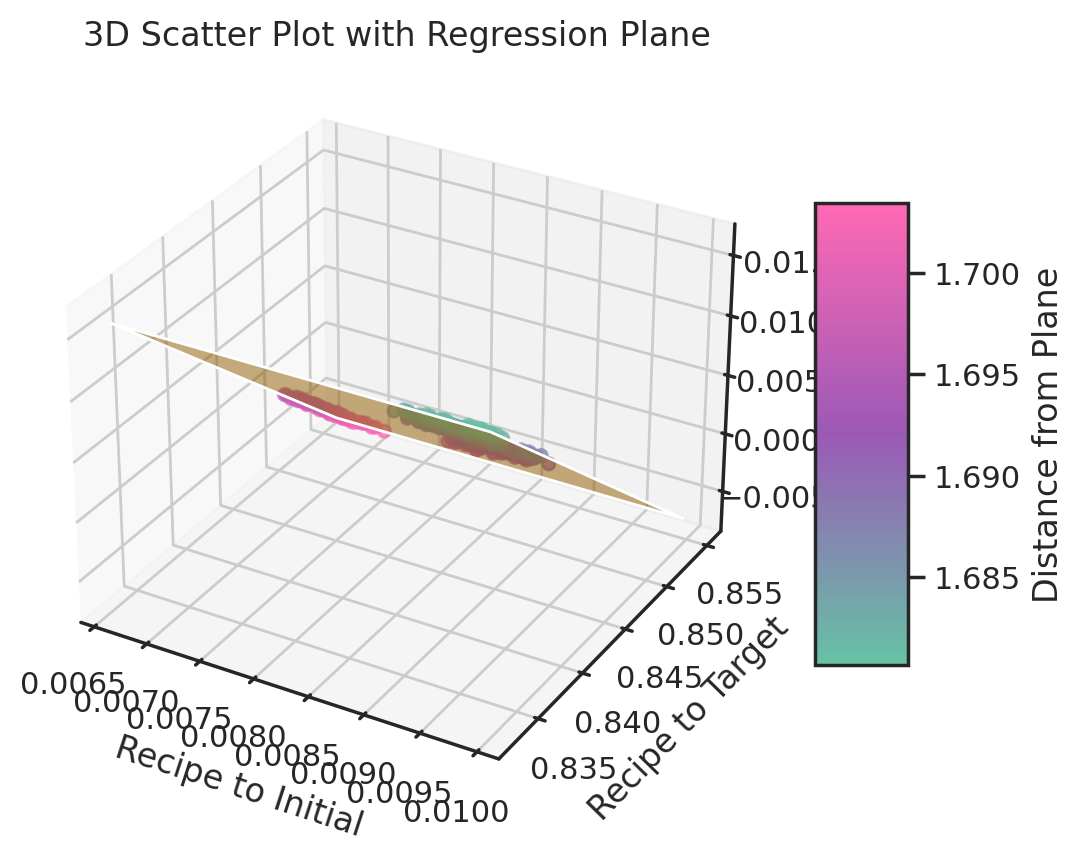

In [144]:
initial = reprogramming_adata.obs[reprogramming_adata.obs['type'] == 'initial']
target = reprogramming_adata.obs[reprogramming_adata.obs['type'] == 'target']
repro = reprogramming_adata.obs[reprogramming_adata.obs['type'] == 'reprogrammed']

# precompute all distances
metric = 'cosine'
D = squareform(pdist(reprogramming_adata.X, metric=metric))
print(f"{D.shape=}")

inital_to_target = D[initial.index, target.index].mean()
print(f"{inital_to_target=:.4f}")

result = []

for i, (recipe, group) in enumerate(repro.groupby('recipe')):
    
    if i % 25 == 0:
        print(f"Recipe {i}/{len(inputs)}...")
    
    # compute group to intial
    recipe_to_initial = D[group.index, initial.index].mean() # average over all cells
    
    # compute group to target
    recipe_to_target = D[group.index, target.index].mean() # average over all cells
    
    row = {
        'recipe' : recipe,
        'recipe_to_initial' : recipe_to_initial,
        'recipe_to_target' : recipe_to_target,
        'recipe_diff' : inital_to_target - recipe_to_target,
    }
    result.append(row)
    
result = pd.DataFrame(result)
result.head(10)


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# # Assuming 'result' is your DataFrame with 252 points
# # Replace this with loading your actual DataFrame
# result = pd.DataFrame({
#     'recipe_to_initial': np.random.rand(252),  # Replace with actual data
#     'recipe_to_target': np.random.rand(252),   # Replace with actual data
#     'recipe_diff': np.random.rand(252)         # Replace with actual data
# })

# Prepare the data
X = result[['recipe_to_initial', 'recipe_to_target']].values
y = result['recipe_diff'].values

# Create a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

# Predict values using the regression model
predicted_diff = linear_regressor.predict(X)

# Calculate distance from the regression plane
coefficients = np.append(linear_regressor.coef_, -linear_regressor.intercept_)
distances = np.abs(np.dot(X, coefficients[:-1]) + coefficients[-1]) / np.linalg.norm(coefficients[:-1])

# Normalize distances to range [0, 1]
norm = plt.Normalize(distances.min(), distances.max())

# Define a custom colormap with more saturated colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#66c2a5", "#9b59b6", "#ff69b4"])  # Saturated Green, Purple, Pink
colors = cmap(norm(distances))

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Revert background color to white
ax.set_facecolor('white')  # Default background color

# Plot the original data points
scatter = ax.scatter(result['recipe_to_initial'], result['recipe_to_target'], result['recipe_diff'], 
                     c=colors, label='Data Points', alpha=0.7)

# Create a grid for the regression plane
x_range = np.linspace(min(result['recipe_to_initial']), max(result['recipe_to_initial']), 10)
y_range = np.linspace(min(result['recipe_to_target']), max(result['recipe_to_target']), 10)
xx, yy = np.meshgrid(x_range, y_range)
zz = linear_regressor.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='orange', alpha=0.5, rstride=100, cstride=100)

# Labels
ax.set_xlabel('Recipe to Initial')
ax.set_ylabel('Recipe to Target')
ax.set_zlabel('Recipe Diff')
ax.set_title('3D Scatter Plot with Regression Plane')

# Create a colorbar
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(distances)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5, label='Distance from Plane')

plt.show()





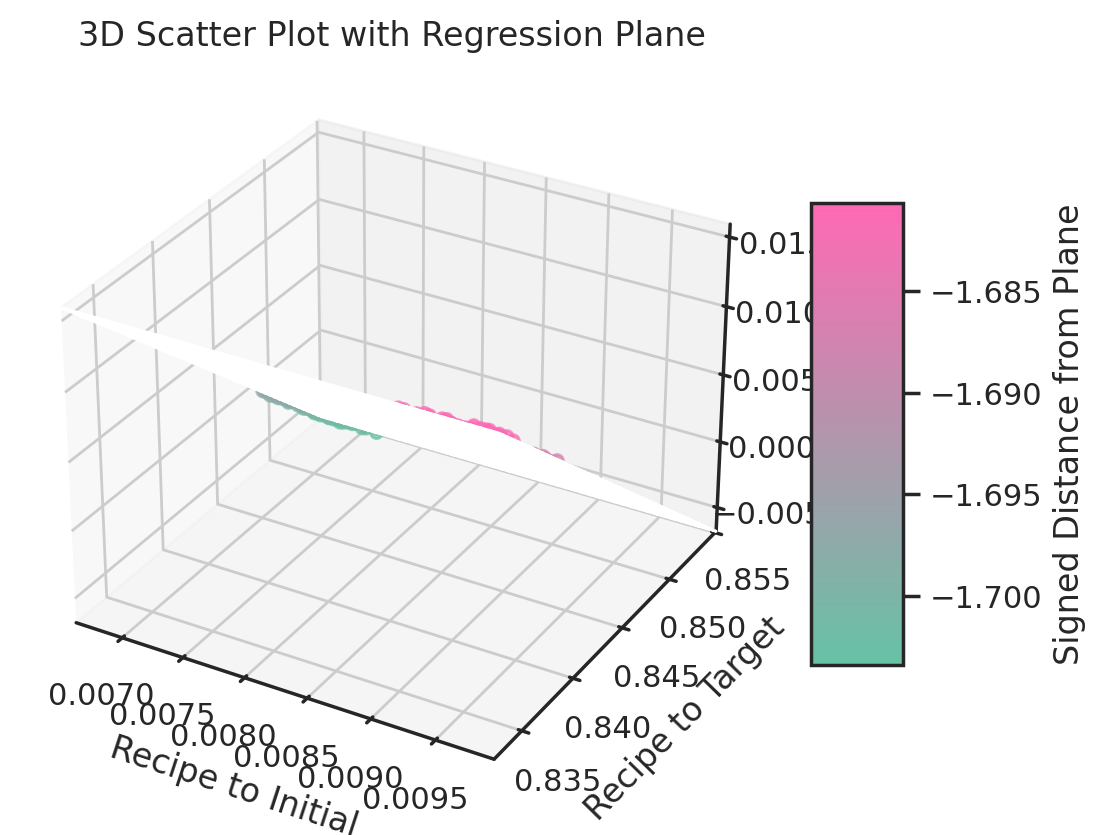

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Prepare the data
X = result[['recipe_to_initial', 'recipe_to_target']].values
y = result['recipe_diff'].values

# Create a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

# Predict values using the regression model
predicted_diff = linear_regressor.predict(X)

# Calculate signed distance from the regression plane
coefficients = np.append(linear_regressor.coef_, -linear_regressor.intercept_)
signed_distances = np.dot(X, coefficients[:-1]) + coefficients[-1]  # No need to normalize distances

# Normalize distances to range [0, 1] for coloring
norm = plt.Normalize(signed_distances.min(), signed_distances.max())

# Define a custom colormap with a gradient for signed distances
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#66c2a5", "#ff69b4"])  # Blue for below, Pink for above
colors = cmap(norm(signed_distances))

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Revert background color to white
ax.set_facecolor('white')  # Default background color

# Plot the original data points
scatter = ax.scatter(result['recipe_to_initial'], result['recipe_to_target'], result['recipe_diff'], 
                     c=colors, label='Data Points', alpha=0.7)

# Set axis limits
ax.set_xlim([result['recipe_to_initial'].min(), result['recipe_to_initial'].max()])
ax.set_ylim([result['recipe_to_target'].min(), result['recipe_to_target'].max()])
ax.set_zlim([result['recipe_diff'].min(), result['recipe_diff'].max()])

# Create a grid for the regression plane with higher resolution
x_range = np.linspace(result['recipe_to_initial'].min(), result['recipe_to_initial'].max(), 50)
y_range = np.linspace(result['recipe_to_target'].min(), result['recipe_to_target'].max(), 50)
xx, yy = np.meshgrid(x_range, y_range)
zz = linear_regressor.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='orange', alpha=0.5, rstride=1, cstride=1)

# Labels
ax.set_xlabel('Recipe to Initial')
ax.set_ylabel('Recipe to Target')
ax.set_zlabel('Recipe Diff')
ax.set_title('3D Scatter Plot with Regression Plane')

# Create a colorbar for signed distances
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(signed_distances)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5, label='Signed Distance from Plane')

plt.show()


In [69]:
import pandas as pd
import numpy as np

# Compute the regression plane coefficients
coef = linear_regressor.coef_
intercept = linear_regressor.intercept_

# Define the regression plane equation: z = coef[0] * x + coef[1] * y + intercept
def regression_plane(x, y):
    return coef[0] * x + coef[1] * y + intercept

# Find points that are above the regression plane and above both xx and yy lines
above_plane = result.apply(
    lambda row: row['recipe_diff'] > regression_plane(row['recipe_to_initial'], row['recipe_to_target']),
    axis=1
)

# Create lists of xx and yy coordinates
x_lines = np.linspace(result['recipe_to_initial'].min(), result['recipe_to_initial'].max(), 50)
y_lines = np.linspace(result['recipe_to_target'].min(), result['recipe_to_target'].max(), 50)

# Create masks for points above both lines
x_line_mask = result['recipe_to_initial'] > x_lines.min()
y_line_mask = result['recipe_to_target'] > y_lines.min()

# Combine masks to get points above both lines
final_mask = above_plane & x_line_mask & y_line_mask

# Get recipe names of filtered points
recipes_above_lines = result[final_mask]['recipe'].tolist()

print("Recipes above both lines and the plane:")
print(recipes_above_lines)


Recipes above both lines and the plane:
[]


In [146]:
# Ensure 'result' DataFrame has the 'recipe' column and relevant data
# Let's use example thresholds for `recipe_to_initial` and `recipe_to_target`
# For demonstration, we assume you have thresholds; replace with your logic as needed

#old thresholds
# Filter conditions based on example thresholds
x_threshold = result['recipe_to_initial'].mean()  # Example threshold for x
y_threshold = result['recipe_to_target'].mean()    # Example threshold for y

# #new thresholds 
# x_threshold = 
# # Get the recipe names that satisfy the conditions
# filtered_recipes = result[(result['recipe_to_initial'] > x_threshold) & 
#                           (result['recipe_to_target'] < y_threshold)]

# Extract the recipe names
recipe_names = filtered_recipes['recipe']

# Output the recipe names
print(recipe_names.tolist())


['ETV6;GFI1B;FOS;GATA2;IKZF1', 'ETV6;REL;FOS;GATA2;IKZF1', 'ETV6;REL;GFI1B;FOS;GATA2', 'ETV6;REL;GFI1B;FOS;IKZF1', 'FOSB;ETV6;GFI1B;GATA2;IKZF1', 'FOSB;ETV6;REL;GATA2;IKZF1', 'FOSB;ETV6;REL;GFI1B;GATA2', 'FOSB;ETV6;REL;GFI1B;IKZF1', 'FOSB;REL;GFI1B;GATA2;IKZF1', 'FOSB;STAT5A;ETV6;GATA2;IKZF1', 'FOSB;STAT5A;ETV6;GFI1B;GATA2', 'FOSB;STAT5A;ETV6;GFI1B;IKZF1', 'FOSB;STAT5A;ETV6;REL;GATA2', 'FOSB;STAT5A;ETV6;REL;GFI1B', 'FOSB;STAT5A;ETV6;REL;IKZF1', 'FOSB;STAT5A;GFI1B;GATA2;IKZF1', 'FOSB;STAT5A;REL;GATA2;IKZF1', 'FOSB;STAT5A;REL;GFI1B;GATA2', 'FOSB;STAT5A;REL;GFI1B;IKZF1', 'MEF2C;ETV6;FOS;GATA2;IKZF1', 'MEF2C;ETV6;GFI1B;FOS;GATA2', 'MEF2C;ETV6;GFI1B;FOS;IKZF1', 'MEF2C;ETV6;REL;FOS;GATA2', 'MEF2C;ETV6;REL;FOS;IKZF1', 'MEF2C;ETV6;REL;GFI1B;FOS', 'MEF2C;FOSB;ETV6;GATA2;IKZF1', 'MEF2C;FOSB;ETV6;GFI1B;GATA2', 'MEF2C;FOSB;ETV6;GFI1B;IKZF1', 'MEF2C;FOSB;ETV6;REL;GATA2', 'MEF2C;FOSB;ETV6;REL;GFI1B', 'MEF2C;FOSB;ETV6;REL;IKZF1', 'MEF2C;FOSB;GFI1B;GATA2;IKZF1', 'MEF2C;FOSB;REL;GATA2;IKZF1', 'MEF2C;FO

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Prepare the data
X = result[['recipe_to_initial', 'recipe_to_target']].values
y = result['recipe_diff'].values

# Create a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

# Predict values using the regression model
predicted_diff = linear_regressor.predict(X)

# Calculate distance from the regression plane
coefficients = np.append(linear_regressor.coef_, -linear_regressor.intercept_)
distances = np.abs(np.dot(X, coefficients[:-1]) + coefficients[-1]) / np.linalg.norm(coefficients[:-1])

# Normalize distances to range [0, 1]
norm = plt.Normalize(distances.min(), distances.max())

# Define the custom colormap for pink gradient (from white to deep pink)
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["#ffffff", "#ff69b4"])  # White to Deep Pink

# Define the blue color
blue_color = "#66c2a5"

# Identify points that meet the criteria
filtered_recipes = result[(result['recipe_to_initial'] > x_threshold) & 
                          (result['recipe_to_target'] < y_threshold)]
filtered_indices = result.index[result['recipe'].isin(filtered_recipes['recipe'])]

# Initialize colors array with blue
colors = np.full(result.shape[0], blue_color)

# Apply the pink gradient only to filtered points
filtered_distances = distances[filtered_indices]
filtered_norm = plt.Normalize(filtered_distances.min(), filtered_distances.max())
filtered_colors = pink_cmap(filtered_norm(filtered_distances))

# Assign pink colors to the filtered points
colors[filtered_indices] = filtered_colors

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Revert background color to white
ax.set_facecolor('white')  # Default background color

# Plot the original data points
scatter = ax.scatter(result['recipe_to_initial'], result['recipe_to_target'], result['recipe_diff'], 
                     c=colors, label='Data Points', alpha=0.7)

# Create a grid for the regression plane
x_range = np.linspace(min(result['recipe_to_initial']), max(result['recipe_to_initial']), 10)
y_range = np.linspace(min(result['recipe_to_target']), max(result['recipe_to_target']), 10)
xx, yy = np.meshgrid(x_range, y_range)
zz = linear_regressor.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='orange', alpha=0.5, rstride=100, cstride=100)

# Labels
ax.set_xlabel('Recipe to Initial')
ax.set_ylabel('Recipe to Target')
ax.set_zlabel('Recipe Diff')
ax.set_title('3D Scatter Plot with Regression Plane')

# Create a colorbar
mappable = plt.cm.ScalarMappable(cmap=pink_cmap, norm=norm)
mappable.set_array(distances)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5, label='Distance from Plane')

plt.show()


ValueError: shape mismatch: value array of shape (153,4) could not be broadcast to indexing result of shape (153,)

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Prepare the data
X = result[['recipe_to_initial', 'recipe_to_target']].values
y = result['recipe_diff'].values

# Create a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

# Predict values using the regression model
predicted_diff = linear_regressor.predict(X)

# Calculate distance from the regression plane
coefficients = np.append(linear_regressor.coef_, -linear_regressor.intercept_)
distances = np.abs(np.dot(X, coefficients[:-1]) + coefficients[-1]) / np.linalg.norm(coefficients[:-1])

# Normalize distances to range [0, 1]
norm = plt.Normalize(distances.min(), distances.max())

# Define the custom colormap for pink gradient (from white to deep pink)
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["#ffffff", "#ff69b4"])  # White to Deep Pink

# Define the blue color
blue_color = "#66c2a5"

# Identify points that meet the criteria
filtered_recipes = result[(result['recipe_to_initial'] > x_threshold) & 
                          (result['recipe_to_target'] < y_threshold)]
filtered_indices = result.index[result['recipe'].isin(filtered_recipes['recipe'])]

# Initialize colors array with blue
colors = np.full((result.shape[0], 4), plt.cm.get_cmap('Blues')(0.5))  # Blue color with alpha = 0.5

# Apply the pink gradient only to filtered points
filtered_distances = distances[filtered_indices]
filtered_norm = plt.Normalize(filtered_distances.min(), filtered_distances.max())
filtered_colors = pink_cmap(filtered_norm(filtered_distances))

# Assign pink colors to the filtered points
colors[filtered_indices] = filtered_colors

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Revert background color to white
ax.set_facecolor('white')  # Default background color

# Plot the original data points
scatter = ax.scatter(result['recipe_to_initial'], result['recipe_to_target'], result['recipe_diff'], 
                     c=colors, label='Data Points', alpha=0.7)

# Create a grid for the regression plane
x_range = np.linspace(min(result['recipe_to_initial']), max(result['recipe_to_initial']), 10)
y_range = np.linspace(min(result['recipe_to_target']), max(result['recipe_to_target']), 10)
xx, yy = np.meshgrid(x_range, y_range)
zz = linear_regressor.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='orange', alpha=0.5, rstride=100, cstride=100)

# Labels
ax.set_xlabel('Recipe to Initial')
ax.set_ylabel('Recipe to Target')
ax.set_zlabel('Recipe Diff')
ax.set_title('3D Scatter Plot with Regression Plane')

# Create a colorbar
mappable = plt.cm.ScalarMappable(cmap=pink_cmap, norm=norm)
mappable.set_array(distances)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5, label='Distance from Plane')

plt.show()


AttributeError: module 'matplotlib.cm' has no attribute 'get_cmap'

### Sorted by Distance from Plane

In [78]:


import numpy as np

# Assuming you already have the distance calculation code
# Calculate distance from the regression plane
def calculate_distance_from_plane(X, coefficients):
    return np.abs(np.dot(X, coefficients[:-1]) + coefficients[-1]) / np.linalg.norm(coefficients[:-1])

# Compute distances for all points in the filtered DataFrame
filtered_X = filtered_recipes[['recipe_to_initial', 'recipe_to_target']].values
filtered_distances = calculate_distance_from_plane(filtered_X, coefficients)

# Add distances to the filtered DataFrame
filtered_recipes['distance_from_plane'] = filtered_distances

# Sort by distance from the plane
sorted_filtered_recipes = filtered_recipes.sort_values(by='distance_from_plane', ascending=False)

# Count the number of points
num_points = sorted_filtered_recipes.shape[0]

# Output sorted recipe names and number of points
sorted_recipe_names = sorted_filtered_recipes['recipe'].tolist()

print(f"Number of points: {num_points}")
print("Sorted recipes by distance from the plane:")
print(sorted_recipe_names)


Number of points: 153
Sorted recipes by distance from the plane:
['RUNX3;STAT5A;ETV6;GATA2;IKZF1', 'MEF2C;STAT5A;REL;GFI1B;IKZF1', 'RUNX3;FOSB;STAT5A;REL;GFI1B', 'MEF2C;STAT5A;ETV6;REL;GATA2', 'RUNX3;MEF2C;STAT5A;GATA2;IKZF1', 'RUNX3;FOSB;REL;GFI1B;IKZF1', 'MEF2C;STAT5A;ETV6;GFI1B;GATA2', 'RUNX3;MEF2C;FOSB;REL;GFI1B', 'RUNX3;FOSB;STAT5A;REL;IKZF1', 'RUNX3;STAT5A;REL;GATA2;IKZF1', 'RUNX3;FOSB;STAT5A;GFI1B;IKZF1', 'RUNX3;STAT5A;GFI1B;GATA2;IKZF1', 'STAT5A;ETV6;REL;GATA2;IKZF1', 'STAT5A;ETV6;GFI1B;GATA2;IKZF1', 'RUNX3;MEF2C;FOSB;STAT5A;GFI1B', 'RUNX3;MEF2C;FOSB;REL;IKZF1', 'RUNX3;FOSB;ETV6;REL;GFI1B', 'RUNX3;MEF2C;FOSB;GFI1B;IKZF1', 'MEF2C;STAT5A;REL;GFI1B;GATA2', 'RUNX3;MEF2C;FOSB;STAT5A;REL', 'RUNX3;MEF2C;FOSB;STAT5A;IKZF1', 'RUNX3;FOSB;REL;GFI1B;GATA2', 'RUNX3;FOSB;STAT5A;REL;GATA2', 'RUNX3;FOSB;STAT5A;ETV6;GFI1B', 'RUNX3;FOSB;ETV6;REL;IKZF1', 'MEF2C;STAT5A;ETV6;GATA2;IKZF1', 'MEF2C;FOSB;STAT5A;REL;GFI1B', 'RUNX3;FOSB;STAT5A;GFI1B;GATA2', 'RUNX3;ETV6;REL;GFI1B;FOS', 'RUNX3;FOSB;STAT5A;

/tmp/ipykernel_42248/1650025336.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
# List of recipe names to filter
recipe_names_of_interest = [
    'RUNX3;STAT5A;ETV6;GATA2;IKZF1',
    'MEF2C;STAT5A;REL;GFI1B;IKZF1',
    'RUNX3;FOSB;STAT5A;REL;GFI1B',
    'MEF2C;STAT5A;ETV6;REL;GATA2',
    'RUNX3;MEF2C;STAT5A;GATA2;IKZF1',
    'RUNX3;FOSB;REL;GFI1B;IKZF1',
    'MEF2C;STAT5A;ETV6;GFI1B;GATA2',
    'RUNX3;MEF2C;FOSB;REL;GFI1B',
    'RUNX3;FOSB;STAT5A;REL;IKZF1',
    'RUNX3;STAT5A;REL;GATA2;IKZF1',
    'RUNX3;FOSB;STAT5A;GFI1B;IKZF1',
    'RUNX3;STAT5A;GFI1B;GATA2;IKZF1',
    'STAT5A;ETV6;REL;GATA2;IKZF1',
    'STAT5A;ETV6;GFI1B;GATA2;IKZF1',
    'RUNX3;MEF2C;FOSB;STAT5A;GFI1B'
]

# Filter the DataFrame to include only these rows
filtered_result = result[result['recipe'].isin(recipe_names_of_interest)]

# Print the filtered DataFrame
print(filtered_result)


                             recipe  recipe_to_initial  recipe_to_target  \
94    MEF2C;STAT5A;ETV6;GFI1B;GATA2           0.009290          0.841062   
97      MEF2C;STAT5A;ETV6;REL;GATA2           0.009435          0.841404   
109    MEF2C;STAT5A;REL;GFI1B;IKZF1           0.009397          0.841490   
140      RUNX3;FOSB;REL;GFI1B;IKZF1           0.008923          0.841088   
151   RUNX3;FOSB;STAT5A;GFI1B;IKZF1           0.009137          0.840729   
154     RUNX3;FOSB;STAT5A;REL;GFI1B           0.009231          0.841455   
155     RUNX3;FOSB;STAT5A;REL;IKZF1           0.009183          0.840974   
181      RUNX3;MEF2C;FOSB;REL;GFI1B           0.009336          0.840994   
186   RUNX3;MEF2C;FOSB;STAT5A;GFI1B           0.009487          0.840464   
205  RUNX3;MEF2C;STAT5A;GATA2;IKZF1           0.009645          0.841220   
219   RUNX3;STAT5A;ETV6;GATA2;IKZF1           0.009156          0.841686   
230  RUNX3;STAT5A;GFI1B;GATA2;IKZF1           0.009526          0.840678   
233    RUNX3

### Sorted by highest to lowest recipe_diff


In [102]:
# Sort filtered_recipes by recipe_diff (high to low)
sorted_filtered_recipes = filtered_recipes.sort_values(by='recipe_diff', ascending=False)

# Count the number of points
num_points = sorted_filtered_recipes.shape[0]

# Output sorted recipe names and number of points
sorted_recipe_names = sorted_filtered_recipes['recipe'].tolist()

print(f"Number of points: {num_points}")
print("Sorted recipes by recipe_diff:")
print(sorted_recipe_names)


Number of points: 153
Sorted recipes by recipe_diff:
['MEF2C;GFI1B;FOS;GATA2;IKZF1', 'MEF2C;STAT5A;FOS;GATA2;IKZF1', 'MEF2C;REL;FOS;GATA2;IKZF1', 'REL;GFI1B;FOS;GATA2;IKZF1', 'STAT5A;GFI1B;FOS;GATA2;IKZF1', 'STAT5A;REL;FOS;GATA2;IKZF1', 'FOSB;STAT5A;ETV6;GATA2;IKZF1', 'ETV6;GFI1B;FOS;GATA2;IKZF1', 'ETV6;REL;FOS;GATA2;IKZF1', 'MEF2C;STAT5A;GFI1B;FOS;GATA2', 'MEF2C;ETV6;FOS;GATA2;IKZF1', 'MEF2C;STAT5A;REL;FOS;GATA2', 'MEF2C;REL;GFI1B;FOS;GATA2', 'STAT5A;ETV6;FOS;GATA2;IKZF1', 'FOSB;ETV6;GFI1B;GATA2;IKZF1', 'STAT5A;REL;GFI1B;FOS;GATA2', 'RUNX3;GFI1B;FOS;GATA2;IKZF1', 'FOSB;ETV6;REL;GATA2;IKZF1', 'RUNX3;STAT5A;FOS;GATA2;IKZF1', 'RUNX3;MEF2C;FOS;GATA2;IKZF1', 'MEF2C;STAT5A;ETV6;FOS;GATA2', 'FOSB;STAT5A;ETV6;GFI1B;GATA2', 'MEF2C;FOSB;ETV6;GATA2;IKZF1', 'RUNX3;REL;FOS;GATA2;IKZF1', 'FOSB;STAT5A;GFI1B;GATA2;IKZF1', 'ETV6;REL;GFI1B;FOS;GATA2', 'FOSB;STAT5A;REL;GATA2;IKZF1', 'FOSB;STAT5A;ETV6;REL;GATA2', 'MEF2C;STAT5A;GFI1B;FOS;IKZF1', 'MEF2C;STAT5A;REL;FOS;IKZF1', 'MEF2C;REL;GFI1B;FOS;IKZF1', '

In [111]:

# Define the list of specific recipes
specific_recipes = [
    'MEF2C;GFI1B;FOS;GATA2;IKZF1',
    'MEF2C;STAT5A;FOS;GATA2;IKZF1',
    'MEF2C;REL;FOS;GATA2;IKZF1',
    'REL;GFI1B;FOS;GATA2;IKZF1',
    'STAT5A;GFI1B;FOS;GATA2;IKZF1',
    'STAT5A;REL;FOS;GATA2;IKZF1',
    'FOSB;STAT5A;ETV6;GATA2;IKZF1',
    'ETV6;GFI1B;FOS;GATA2;IKZF1',
    'ETV6;REL;FOS;GATA2;IKZF1',
    'MEF2C;STAT5A;GFI1B;FOS;GATA2'
]

# Filter the recipes DataFrame to include only the rows with the specific recipes
filtered_recipes_df = result[result['recipe'].isin(specific_recipes)]

# Output the filtered recipes DataFrame
print("Filtered recipes with specific recipes:")
print(filtered_recipes_df)


Filtered recipes with specific recipes:
                           recipe  recipe_to_initial  recipe_to_target  \
0      ETV6;GFI1B;FOS;GATA2;IKZF1           0.009329          0.833353   
1        ETV6;REL;FOS;GATA2;IKZF1           0.009438          0.833575   
22   FOSB;STAT5A;ETV6;GATA2;IKZF1           0.009501          0.833217   
85    MEF2C;GFI1B;FOS;GATA2;IKZF1           0.009767          0.832377   
86      MEF2C;REL;FOS;GATA2;IKZF1           0.009838          0.832633   
100  MEF2C;STAT5A;FOS;GATA2;IKZF1           0.009878          0.832422   
101  MEF2C;STAT5A;GFI1B;FOS;GATA2           0.009807          0.833832   
110     REL;GFI1B;FOS;GATA2;IKZF1           0.009778          0.832854   
247  STAT5A;GFI1B;FOS;GATA2;IKZF1           0.009904          0.832973   
248    STAT5A;REL;FOS;GATA2;IKZF1           0.009947          0.833145   

     recipe_diff          color  
0       0.014943  (1, 0.8, 0.8)  
1       0.014722  (1, 0.8, 0.8)  
22      0.015079  (1, 0.8, 0.8)  
85      0

### Plots, colored furthest from plane (3d), high-to-low diff (2d)

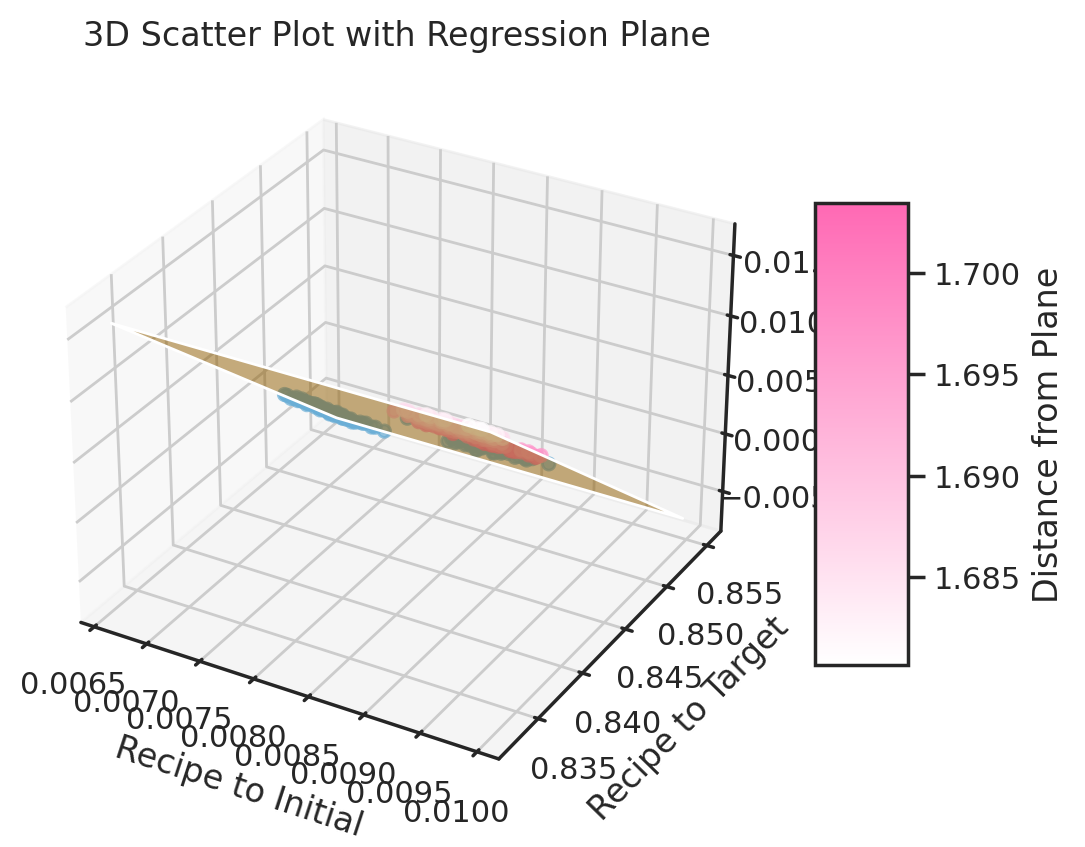

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Prepare the data
X = result[['recipe_to_initial', 'recipe_to_target']].values
y = result['recipe_diff'].values

# Create a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

# Predict values using the regression model
predicted_diff = linear_regressor.predict(X)

# Calculate distance from the regression plane
coefficients = np.append(linear_regressor.coef_, -linear_regressor.intercept_)
distances = np.abs(np.dot(X, coefficients[:-1]) + coefficients[-1]) / np.linalg.norm(coefficients[:-1])

# Normalize distances to range [0, 1]
norm = plt.Normalize(distances.min(), distances.max())

# Define the custom colormap for pink gradient (from white to deep pink)
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["#ffffff", "#ff69b4"])  # White to Deep Pink

# Define the blue color
blue_cmap = plt.get_cmap('Blues')

# Identify points that meet the criteria
filtered_recipes = result[(result['recipe_to_initial'] > x_threshold) & 
                          (result['recipe_to_target'] < y_threshold)]
filtered_indices = result.index[result['recipe'].isin(filtered_recipes['recipe'])]

# Initialize colors array with blue
colors = np.tile(blue_cmap(0.5), (result.shape[0], 1))  # Blue color with alpha = 0.5

# Apply the pink gradient only to filtered points
filtered_distances = distances[filtered_indices]
filtered_norm = plt.Normalize(filtered_distances.min(), filtered_distances.max())
filtered_colors = pink_cmap(filtered_norm(filtered_distances))

# Assign pink colors to the filtered points
colors[filtered_indices] = filtered_colors

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Revert background color to white
ax.set_facecolor('white')  # Default background color

# Plot the original data points
scatter = ax.scatter(result['recipe_to_initial'], result['recipe_to_target'], result['recipe_diff'], 
                     c=colors, label='Data Points', alpha=0.7)

# Create a grid for the regression plane
x_range = np.linspace(min(result['recipe_to_initial']), max(result['recipe_to_initial']), 10)
y_range = np.linspace(min(result['recipe_to_target']), max(result['recipe_to_target']), 10)
xx, yy = np.meshgrid(x_range, y_range)
zz = linear_regressor.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='orange', alpha=0.5, rstride=100, cstride=100)

# Labels
ax.set_xlabel('Recipe to Initial')
ax.set_ylabel('Recipe to Target')
ax.set_zlabel('Recipe Diff')
ax.set_title('3D Scatter Plot with Regression Plane')

# Create a colorbar
mappable = plt.cm.ScalarMappable(cmap=pink_cmap, norm=norm)
mappable.set_array(distances)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5, label='Distance from Plane')

plt.show()


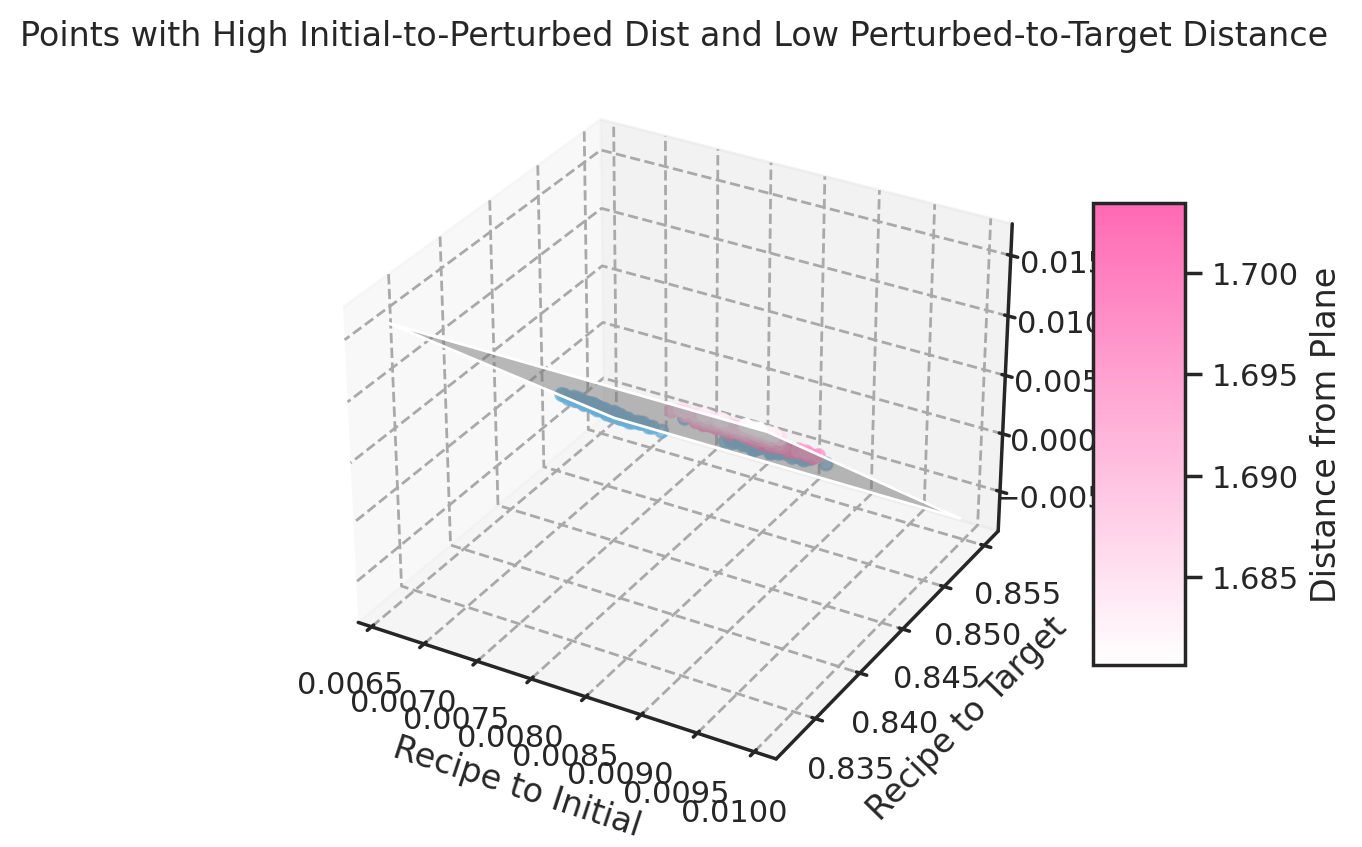

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Prepare the data
X = result[['recipe_to_initial', 'recipe_to_target']].values
y = result['recipe_diff'].values

# Create a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

# Predict values using the regression model
predicted_diff = linear_regressor.predict(X)

# Calculate distance from the regression plane
coefficients = np.append(linear_regressor.coef_, -linear_regressor.intercept_)
distances = np.abs(np.dot(X, coefficients[:-1]) + coefficients[-1]) / np.linalg.norm(coefficients[:-1])

# Normalize distances to range [0, 1]
norm = plt.Normalize(distances.min(), distances.max())

# Define the custom colormap for pink gradient (from white to deep pink)
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["#ffffff", "#ff69b4"])  # White to Deep Pink

# Define the blue color
blue_cmap = plt.get_cmap('Blues')

# Identify points that meet the criteria
filtered_recipes = result[(result['recipe_to_initial'] > x_threshold) & 
                          (result['recipe_to_target'] < y_threshold)]
filtered_indices = result.index[result['recipe'].isin(filtered_recipes['recipe'])]

# Initialize colors array with blue
colors = np.tile(blue_cmap(0.5), (result.shape[0], 1))  # Blue color with alpha = 0.5

# Apply the pink gradient only to filtered points
filtered_distances = distances[filtered_indices]
filtered_norm = plt.Normalize(filtered_distances.min(), filtered_distances.max())
filtered_colors = pink_cmap(filtered_norm(filtered_distances))

# Assign pink colors to the filtered points
colors[filtered_indices] = filtered_colors

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Revert background color to white
ax.set_facecolor('white')  # Default background color

# Plot the original data points
scatter = ax.scatter(result['recipe_to_initial'], result['recipe_to_target'], result['recipe_diff'], 
                     c=colors, label='Data Points', alpha=0.7)

# Create a grid for the regression plane
x_range = np.linspace(min(result['recipe_to_initial']), max(result['recipe_to_initial']), 10)
y_range = np.linspace(min(result['recipe_to_target']), max(result['recipe_to_target']), 10)
xx, yy = np.meshgrid(x_range, y_range)
zz = linear_regressor.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot the regression plane with light gray color
ax.plot_surface(xx, yy, zz, color='lightgray', alpha=0.5, rstride=100, cstride=100)

# Set grid color to darker gray
ax.xaxis._axinfo['grid'].update(color = 'darkgray', linestyle = '--')
ax.yaxis._axinfo['grid'].update(color = 'darkgray', linestyle = '--')
ax.zaxis._axinfo['grid'].update(color = 'darkgray', linestyle = '--')

# Labels
ax.set_xlabel('Recipe to Initial')
ax.set_ylabel('Recipe to Target')
ax.set_zlabel('Recipe Diff')
ax.set_title('Points with High Initial-to-Perturbed Dist and Low Perturbed-to-Target Distance')

# Create a colorbar
mappable = plt.cm.ScalarMappable(cmap=pink_cmap, norm=norm)
mappable.set_array(distances)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5, label='Distance from Plane')

plt.show()


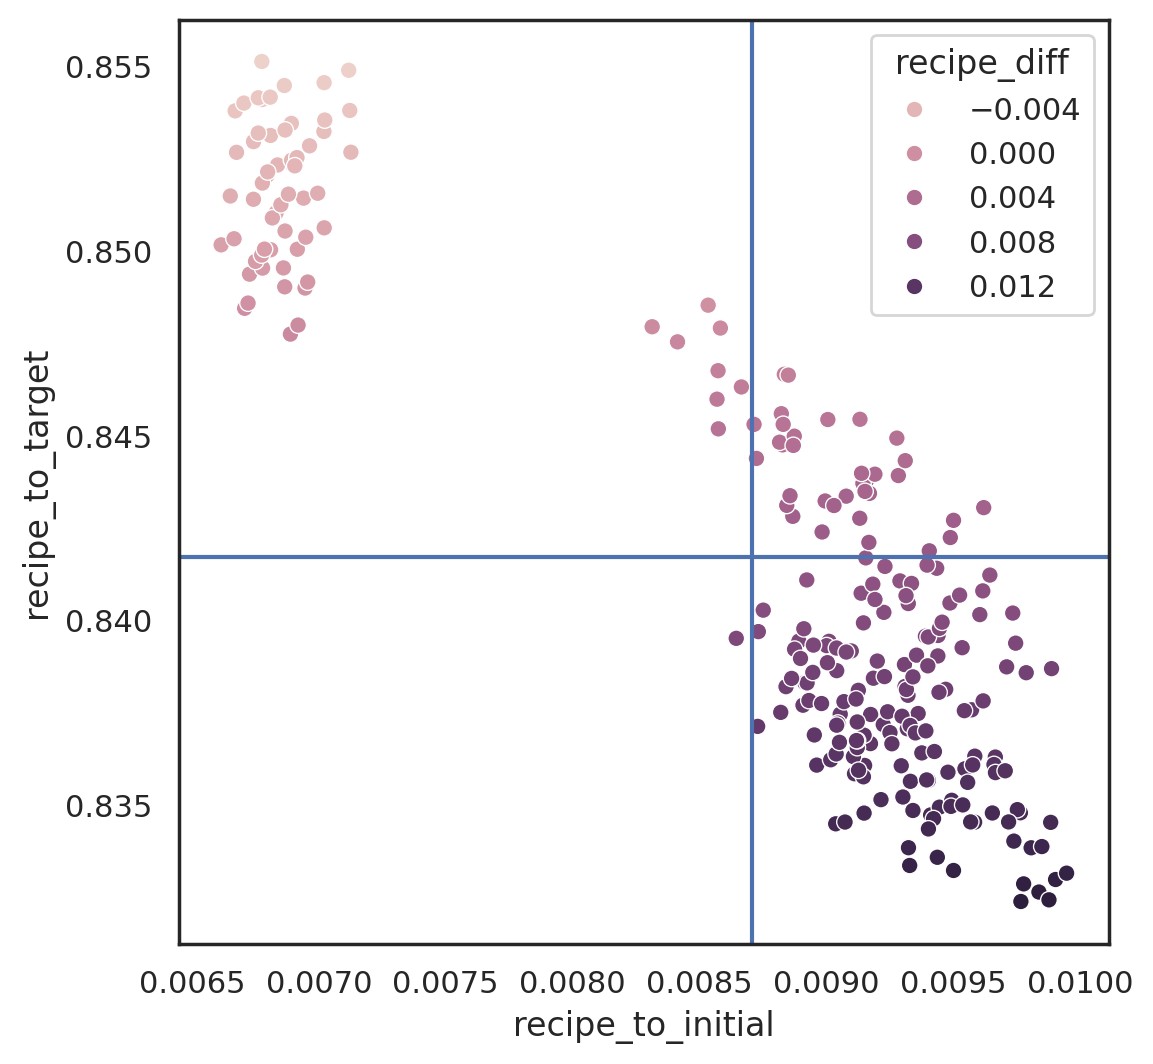

In [147]:
sns.scatterplot(
    data=result,
    x='recipe_to_initial',
    y='recipe_to_target',
    hue='recipe_diff'
)

# sns.scatterplot(
#     data=result,
#     x='recipe_diff',
#     y='recipe_to_initial',
#     hue='recipe_to_target'

# )
# plt.axvline(x=0.0096)
# plt.axhline(y=.835)

plt.axvline(x=x_threshold)
plt.axhline(y=y_threshold)

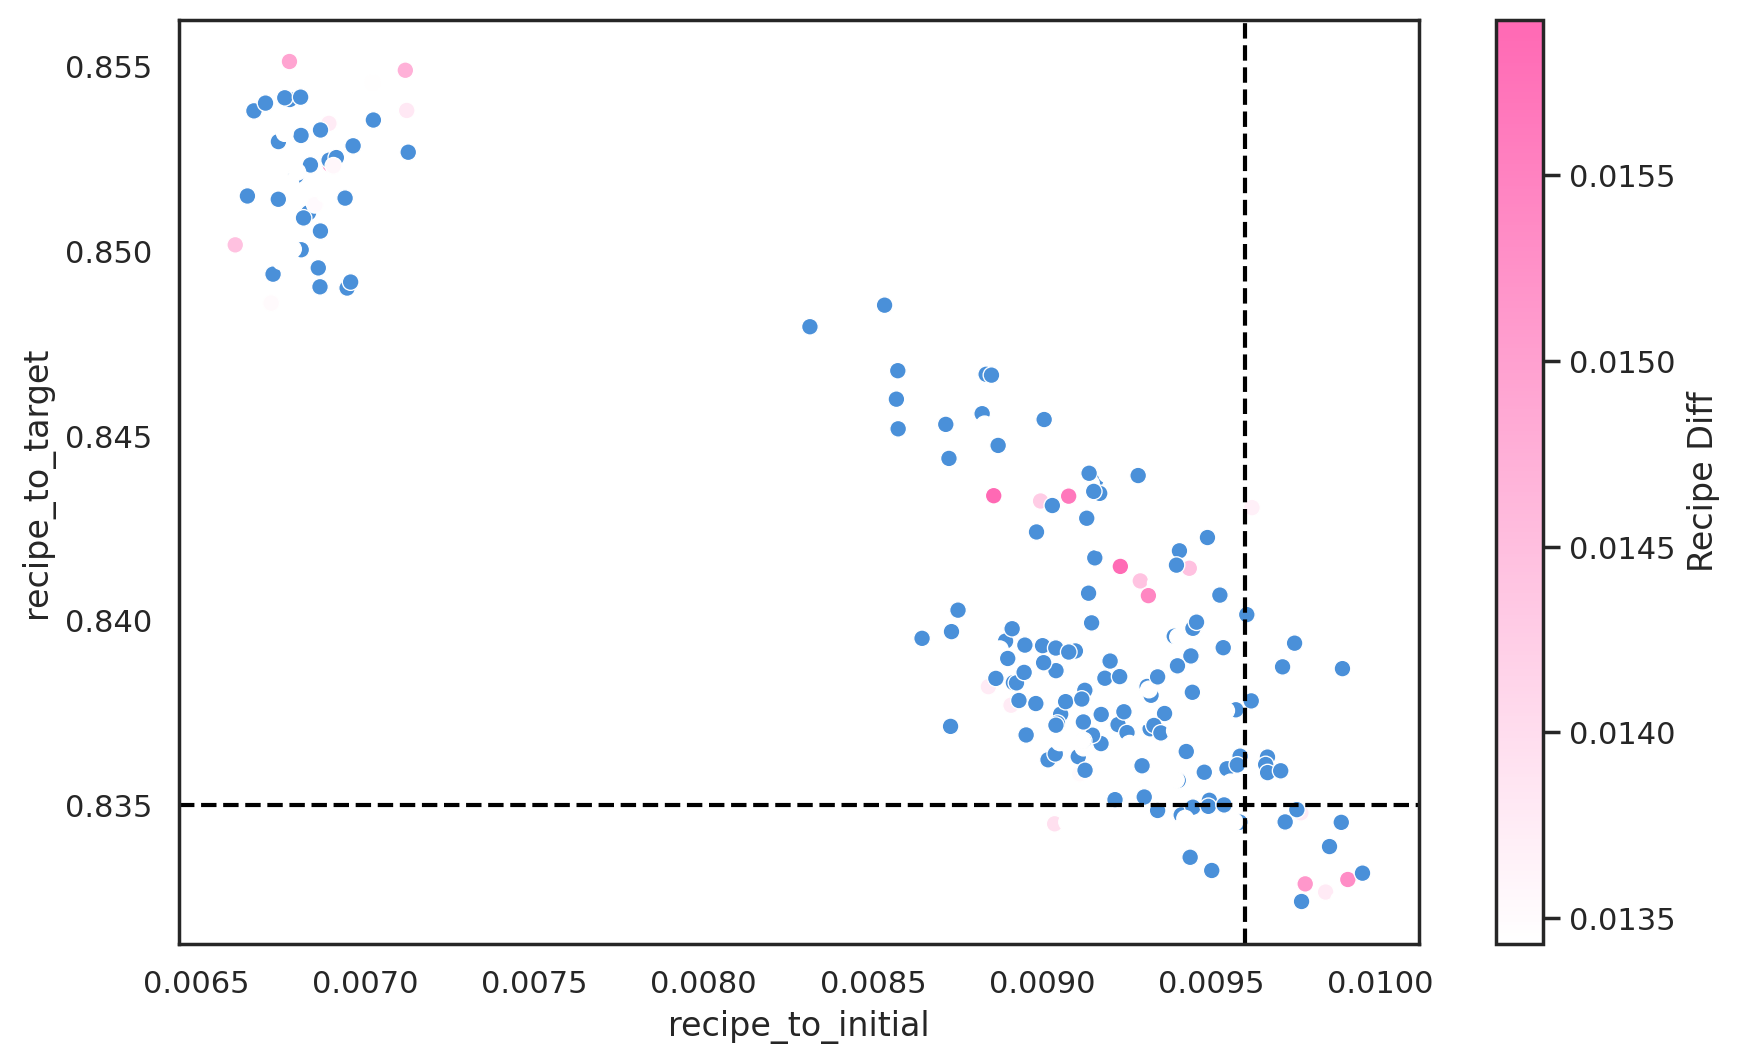

In [113]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming result DataFrame is already defined

# Create a color gradient for points in the specified region
cmap = mcolors.LinearSegmentedColormap.from_list('gradient', ['#ffffff', '#ff69b4'])
norm = plt.Normalize(result.loc[(result['recipe_to_initial'] > x_threshold) & 
                                (result['recipe_to_target'] < y_threshold), 'recipe_diff'].min(), 
                     result.loc[(result['recipe_to_initial'] > x_threshold) & 
                                (result['recipe_to_target'] < y_threshold), 'recipe_diff'].max())

# Create the scatterplot
plt.figure(figsize=(10, 6))

# Plot all points
sns.scatterplot(
    data=result,
    x='recipe_to_initial',
    y='recipe_to_target',
    hue='recipe_diff',
    palette=[cmap(norm(value)) if value > x_threshold and value < y_threshold else '#4a90d9' for value in result['recipe_diff']],
    legend=False
)

# Draw vertical and horizontal lines
plt.axvline(x=x_threshold, color='black', linestyle='--')
plt.axhline(y=y_threshold, color='black', linestyle='--')

# Add a colorbar for the gradient
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Recipe Diff')

plt.show()


/tmp/ipykernel_42248/3263255725.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_42248/3263255725.py:47: UserWarning:


The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.



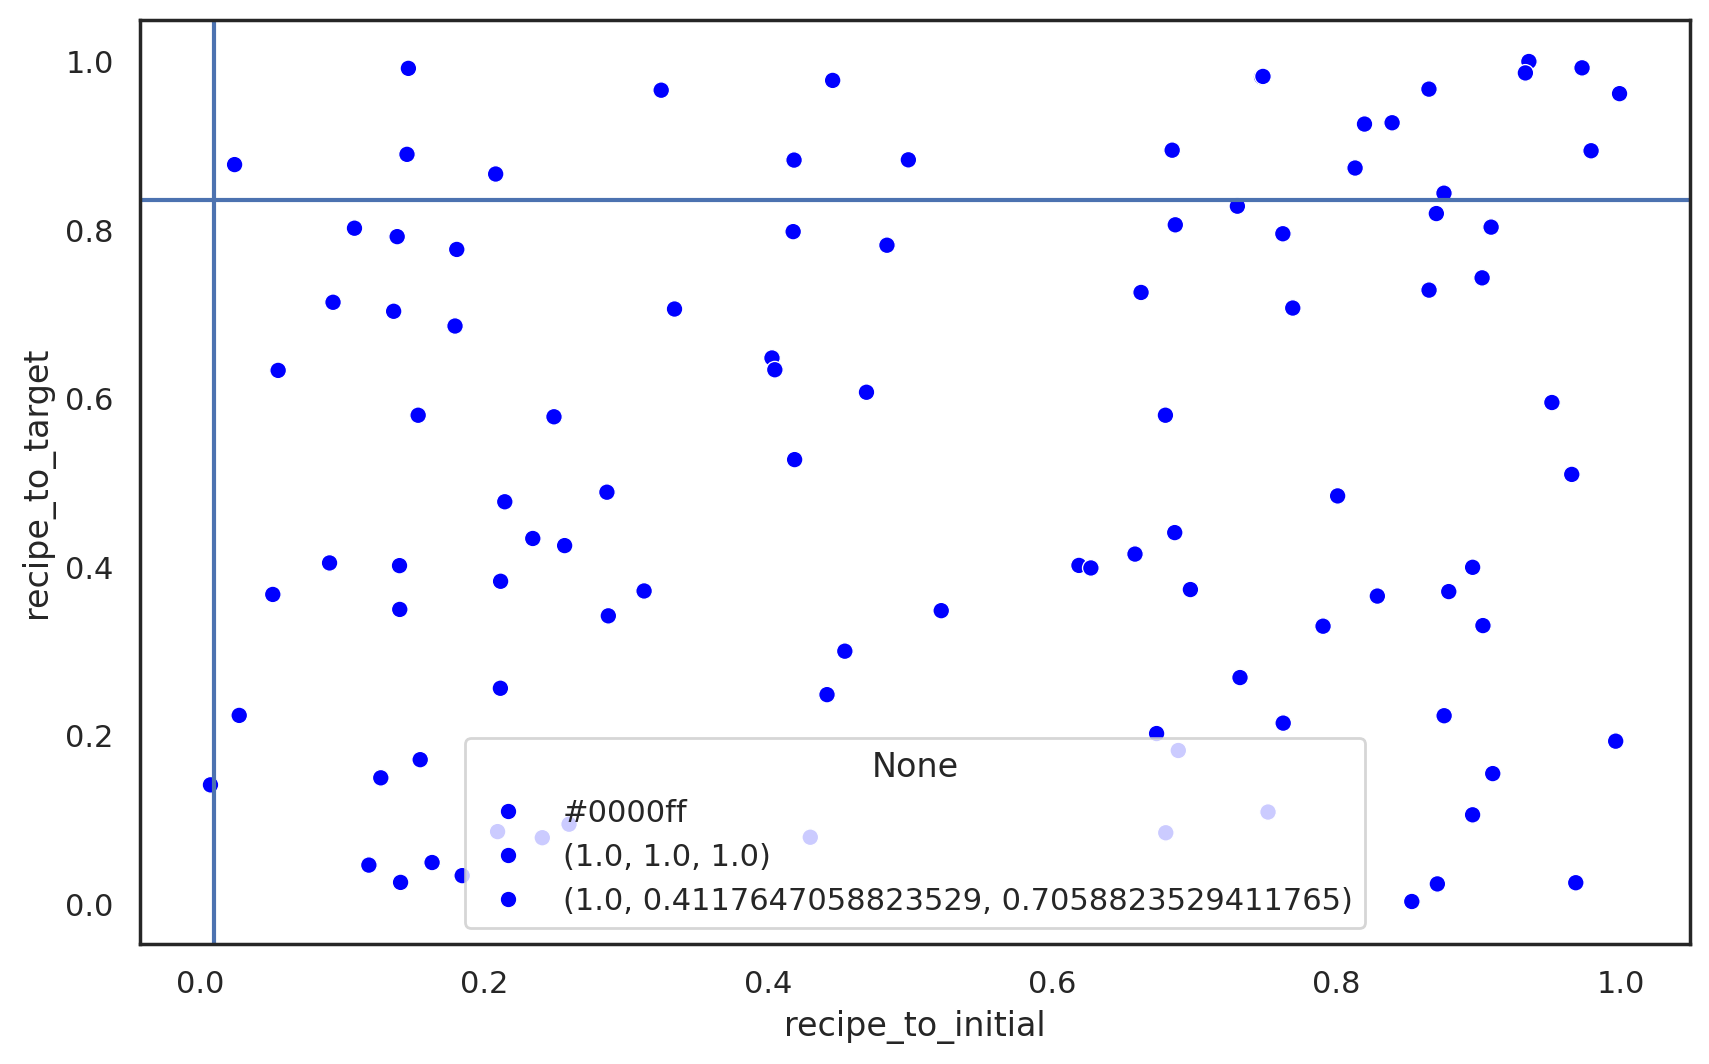

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame
# result = pd.DataFrame({
#     'recipe_to_initial': np.random.rand(252),
#     'recipe_to_target': np.random.rand(252),
#     'recipe_diff': np.random.rand(252)
# })



# Define colors
gradient_start = '#ffffff'  # white
gradient_end = '#ff69b4'    # hot pink
blue_color = '#0000ff'      # blue

# Filter subset
subset = result[(result['recipe_to_initial'] > x_threshold) &
                (result['recipe_to_target'] < y_threshold)]

# Normalize recipe_diff in the subset
min_diff = subset['recipe_diff'].min()
max_diff = subset['recipe_diff'].max()
subset['color'] = subset['recipe_diff'].apply(lambda x: np.interp(x, [min_diff, max_diff], [0, 1]))

# Create color mapping dictionary
color_map = {}
for index, row in subset.iterrows():
    color_map[row.name] = sns.color_palette([gradient_start, gradient_end])[int(row['color']*255/255)]

# Add uniform color for other points
blue_points = result[~result.index.isin(subset.index)]
for index in blue_points.index:
    color_map[index] = blue_color

# Define get_color function
def get_color(recipe_index):
    return color_map.get(recipe_index, blue_color)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=result,
    x='recipe_to_initial',
    y='recipe_to_target',
    hue=result.index.map(get_color),
    palette=[blue_color]  # Ensures the default color is blue
)
plt.axvline(x=x_threshold)
plt.axhline(y=y_threshold)
plt.show()


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

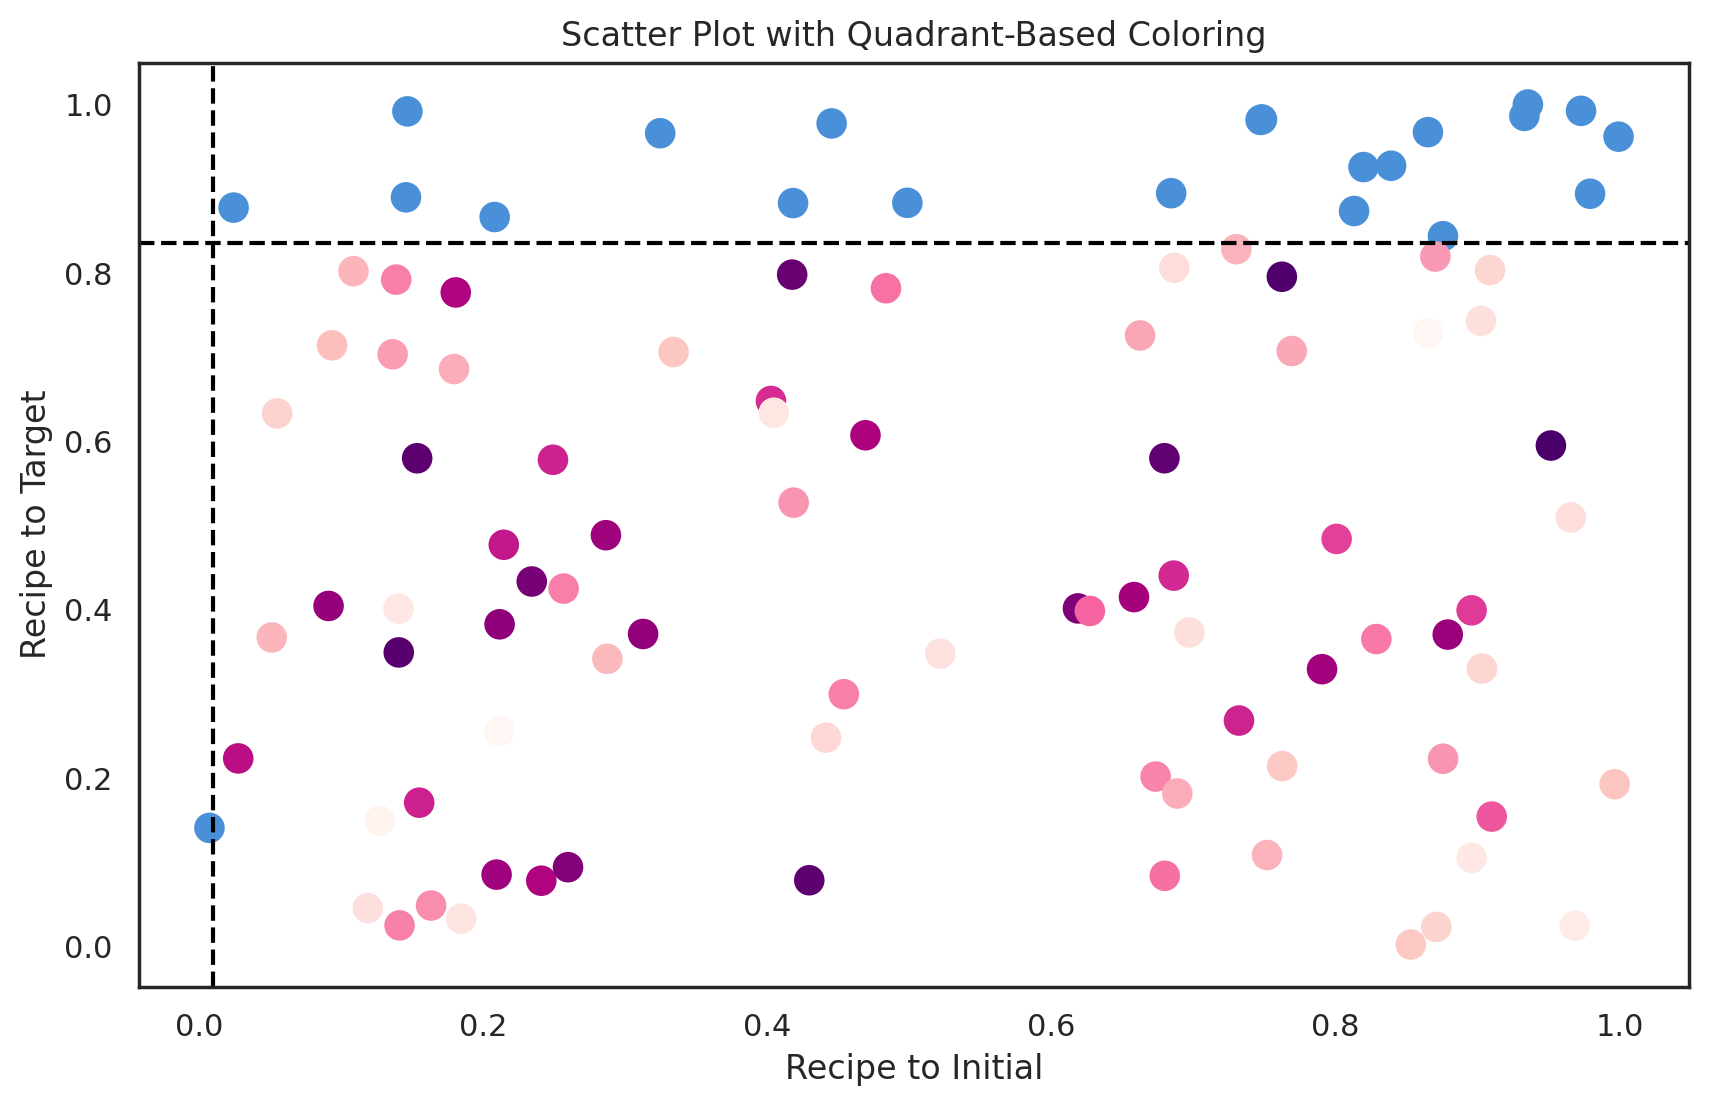

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# Define the gradient function using a colormap
def gradient_color(value, min_value, max_value):
    norm = (value - min_value) / (max_value - min_value)
    cmap = plt.get_cmap('RdPu')  # White to pink colormap
    return cmap(norm)

# Filter the quadrant where the gradient should be applied
filtered_data = result[(result['recipe_to_initial'] > x_threshold) & 
                       (result['recipe_to_target'] < y_threshold)]

# Get min and max recipe_diff values in the specified quadrant
min_diff = filtered_data['recipe_diff'].min()
max_diff = filtered_data['recipe_diff'].max()

# # Apply colors based on conditions
# result['color'] = np.where(
#     (result['recipe_to_initial'] > x_threshold) & 
#     (result['recipe_to_target'] < y_threshold),
#     [gradient_color(diff, min_diff, max_diff) for diff in filtered_data['recipe_diff']],
#     '#4a90d9'  # Blue for other quadrants
# )

def get_color(row):
    if (row['recipe_to_initial'] > x_threshold) and (row['recipe_to_target'] < y_threshold):
        # Apply gradient color based on recipe_diff
        return gradient_color(row['recipe_diff'], min_diff, max_diff)
    else:
        # Apply fixed color for other quadrants
        return '#4a90d9'

# Apply colors based on conditions
result['color'] = result.apply(get_color, axis=1)

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x=result['recipe_to_initial'],
    y=result['recipe_to_target'],
    c=result['color'],
    s=100  # Size of the points
)

# Add vertical and horizontal lines
plt.axvline(x=x_threshold, color='black', linestyle='--')
plt.axhline(y=y_threshold, color='black', linestyle='--')

plt.xlabel('Recipe to Initial')
plt.ylabel('Recipe to Target')
plt.title('Scatter Plot with Quadrant-Based Coloring')

# Create a colorbar for the gradient
norm = mcolors.Normalize(vmin=min_diff, vmax=max_diff)
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=[min_diff, max_diff])
cbar.set_label('Recipe Diff')
cbar.set_ticks([min_diff, max_diff])
cbar.ax.set_yticklabels([f'{min_diff:.4f}', f'{max_diff:.4f}'])

plt.show()


In [117]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd

# Sample DataFrame setup
# Replace this with the actual DataFrame 'result' you are working with
result = pd.DataFrame({
    'recipe_to_initial': np.random.rand(100),
    'recipe_to_target': np.random.rand(100),
    'recipe_diff': np.random.rand(100)
})

# Define your threshold values
x_threshold = 0.0096
y_threshold = 0.835

# Define the gradient function using a colormap
def gradient_color(value, min_value, max_value):
    norm = (value - min_value) / (max_value - min_value)
    cmap = plt.get_cmap('RdPu')  # White to pink colormap
    return cmap(norm)

# Filter the quadrant where the gradient should be applied
filtered_data = result[(result['recipe_to_initial'] > x_threshold) & 
                       (result['recipe_to_target'] < y_threshold)]

# Get min and max recipe_diff values in the specified quadrant
min_diff = filtered_data['recipe_diff'].min()
max_diff = filtered_data['recipe_diff'].max()

# Apply colors based on conditions
result['color'] = np.where(
    (result['recipe_to_initial'] > x_threshold) & 
    (result['recipe_to_target'] < y_threshold),
    [gradient_color(diff, min_diff, max_diff) for diff in result['recipe_diff']],
    '#4a90d9'  # Blue for other quadrants
)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    x=result['recipe_to_initial'],
    y=result['recipe_to_target'],
    c=result['color'],
    s=100  # Size of the points
)

# Add vertical and horizontal lines
plt.axvline(x=x_threshold, color='black', linestyle='--')
plt.axhline(y=y_threshold, color='black', linestyle='--')

plt.xlabel('Recipe to Initial')
plt.ylabel('Recipe to Target')
plt.title('Scatter Plot with Quadrant-Based Coloring')

# Create a colorbar for the gradient
norm = mcolors.Normalize(vmin=min_diff, vmax=max_diff)
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=[min_diff, max_diff])
cbar.set_label('Recipe Diff')
cbar.set_ticks([min_diff, max_diff])
cbar.ax.set_yticklabels([f'{min_diff:.4f}', f'{max_diff:.4f}'])

plt.show()


ValueError: operands could not be broadcast together with shapes (100,) (100,4) () 

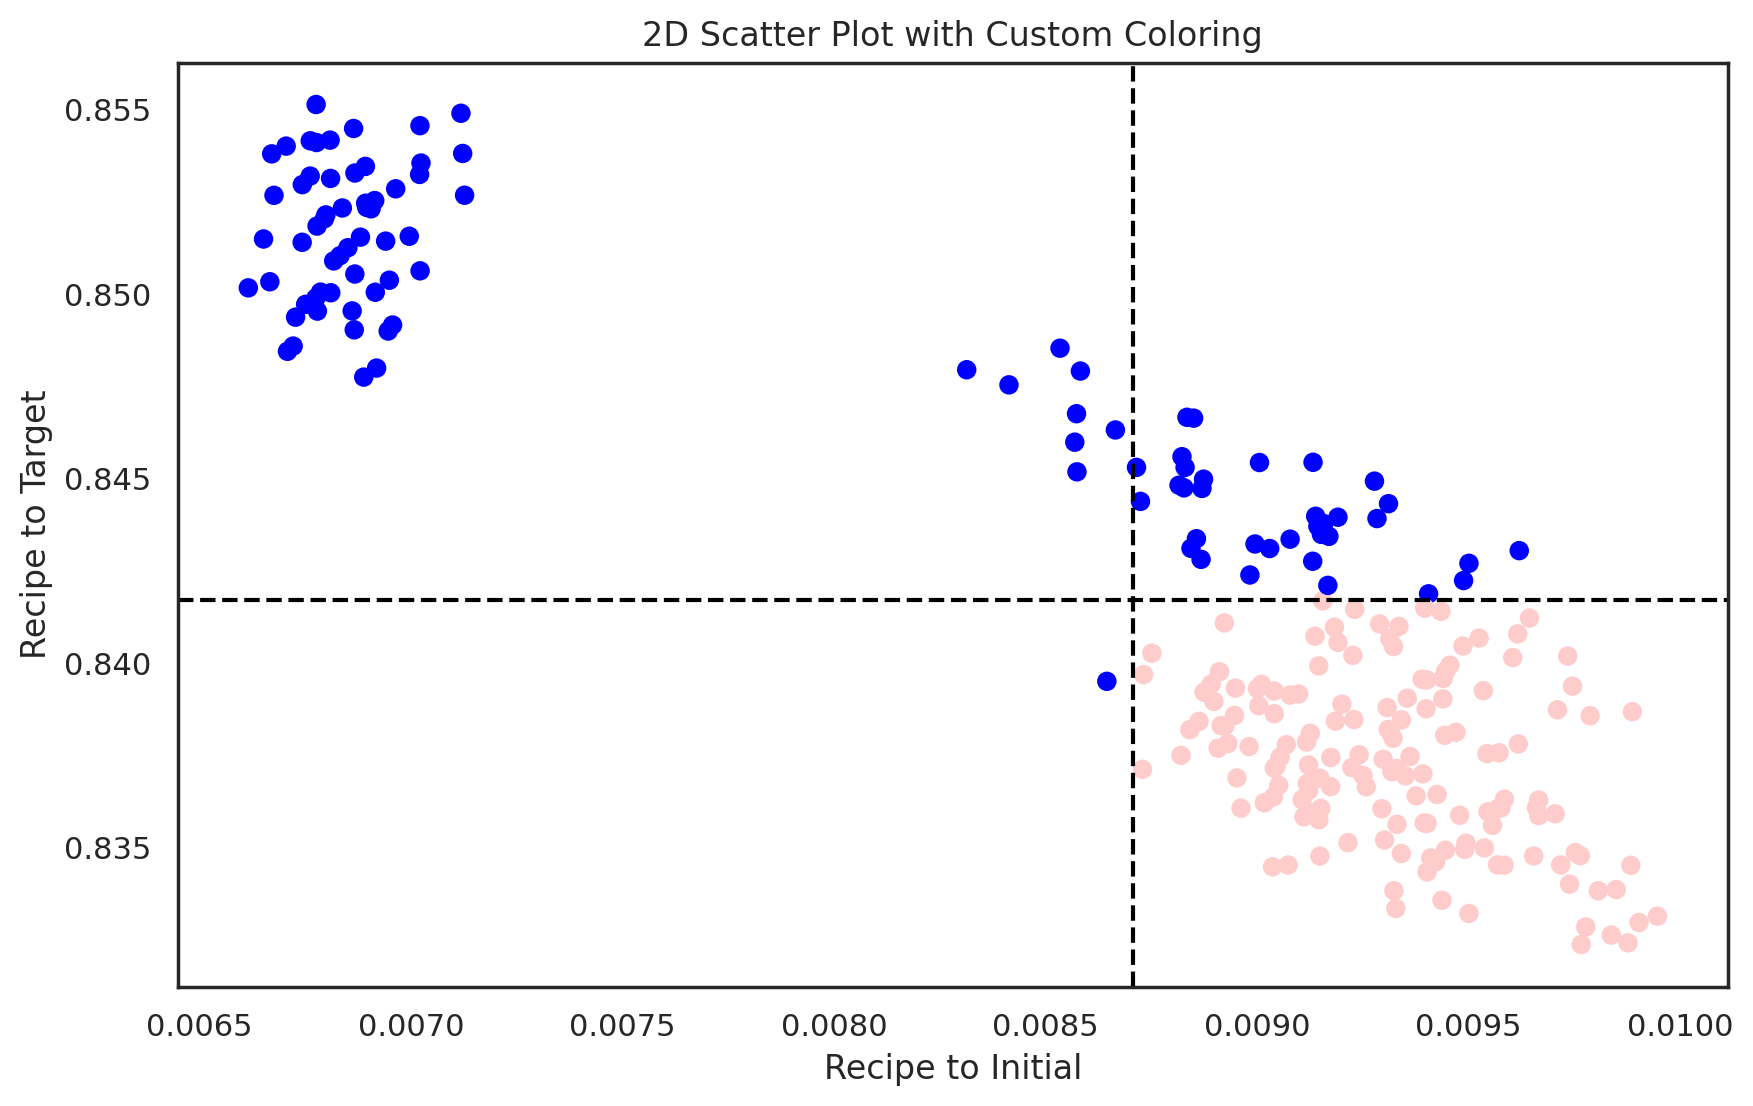

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

# Example data (make sure to use your actual DataFrame)
# result = pd.DataFrame({
#     'recipe_to_initial': ...,
#     'recipe_to_target': ...,
#     'recipe_diff': ...,
# })

# Define colors
def color_map(x, y, x_threshold, y_threshold):
    if x > x_threshold and y < y_threshold:
        return (1, 0.8, 0.8)  # Light pink
    else:
        return (0, 0, 1)  # Blue

# Apply the color mapping to each point
result['color'] = [color_map(x, y, x_threshold, y_threshold) for x, y in zip(result['recipe_to_initial'], result['recipe_to_target'])]

# Plot with the custom colors
plt.figure(figsize=(10, 6))
plt.scatter(
    data=result,
    x='recipe_to_initial',
    y='recipe_to_target',
    c=result['color'],
    edgecolor=None
)

# Add vertical and horizontal lines
plt.axvline(x=x_threshold, color='black', linestyle='--')
plt.axhline(y=y_threshold, color='black', linestyle='--')

plt.title('2D Scatter Plot with Custom Coloring')
plt.xlabel('Recipe to Initial')
plt.ylabel('Recipe to Target')

plt.show()



ValueError: operands could not be broadcast together with shapes (252,) (252,4) () 

In [61]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming the DataFrame `recipes` has columns: 'recipe_to_initial', 'recipe_to_target', 'recipe_diff'

# Extract the data
X = recipes[['recipe_to_initial', 'recipe_to_target']].values
y = recipes['recipe_diff'].values

# Create and fit the linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

# Predict values using the regression model
predicted_diff = linear_regressor.predict(X)

# Determine which recipes are above the regression plane
recipes['predicted_diff'] = predicted_diff
recipes_above_plane = recipes[recipes['recipe_diff'] > recipes['predicted_diff']]

# Display the recipes that are above the regression plane
print("Recipes above the regression plane:")
print(recipes_above_plane[['recipe', 'recipe_diff', 'predicted_diff']])



TypeError: list indices must be integers or slices, not list

## More cooper's plots

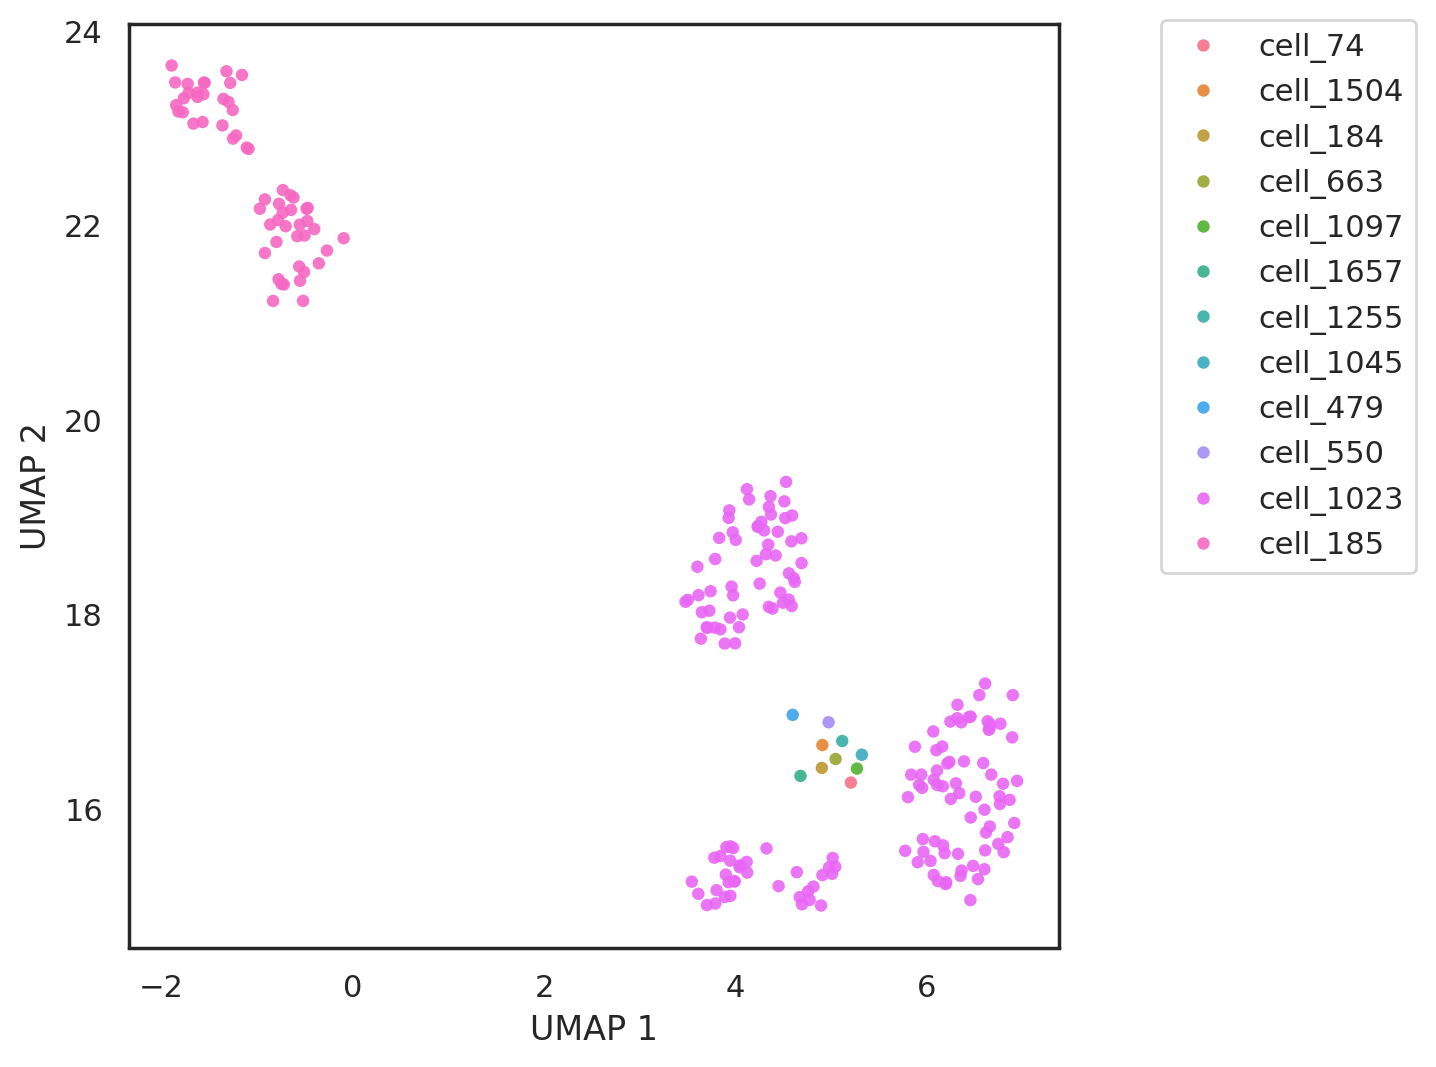

In [32]:
pdf = reprogramming_adata.obs.copy()
pdf['UMAP 1'] = reprogramming_adata.obsm['X_umap'][:, 0]
pdf['UMAP 2'] = reprogramming_adata.obsm['X_umap'][:, 1]


# # extract the cells by UMAP coords
pdf = pdf[(pdf['UMAP 1'] < 10) & (pdf['UMAP 1'] > -5)]
pdf = pdf[(pdf['UMAP 2'] < 25) & (pdf['UMAP 2'] > 15)]

pdf = pdf.sort_values(by='type', ascending=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.scatterplot(
    data=pdf,
    x='UMAP 1',
    y='UMAP 2',
    hue='cell_id',
    ec='none',
    s=20,
    alpha=0.9,
    zorder=1
)

# # Add plot details
# plt.yticks([])
# plt.xticks([])
# # plt.title('All Cells')

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper right',
    bbox_to_anchor=(1.4, 1.02),
)

## Nat's Plots

In [33]:
# all lists of length less than 5
def get_sub_sublists(genes):
    sublists = []
    for length in range(1, 5):
        sublists.extend(combinations(genes, length))
    return sublists

# Create a dictionary to store ranks for each sublist
sublists_ranks = {}

# Loop through each recipe and rank
for idx, row in result.iterrows():
    genes = row['recipe'].split(';')
    rank = row['rank']
    sublists = get_sub_sublists(genes)
    
    for sublist in sublists:
        sublist_str = ';'.join(sublist)
        if sublist_str not in sublists_ranks:
            sublists_ranks[sublist_str] = []
        sublists_ranks[sublist_str].append(rank)

# Calculate average rank for each sublist
average_ranks = {sublist: sum(ranks) / len(ranks) for sublist, ranks in sublists_ranks.items()}

# Print the result
for sublist, avg_rank in average_ranks.items():
    print(f"Sublists: {sublist}, Average Rank: {avg_rank}")

Sublists: RUNX3, Average Rank: 110.4920634920635
Sublists: FOSB, Average Rank: 102.83333333333333
Sublists: REL, Average Rank: 126.67460317460318
Sublists: GFI1B, Average Rank: 127.95238095238095
Sublists: FOS, Average Rank: 124.25396825396825
Sublists: RUNX3;FOSB, Average Rank: 88.0
Sublists: RUNX3;REL, Average Rank: 105.98214285714286
Sublists: RUNX3;GFI1B, Average Rank: 107.33928571428571
Sublists: RUNX3;FOS, Average Rank: 116.92857142857143
Sublists: FOSB;REL, Average Rank: 107.96428571428571
Sublists: FOSB;GFI1B, Average Rank: 109.21428571428571
Sublists: FOSB;FOS, Average Rank: 28.589285714285715
Sublists: REL;GFI1B, Average Rank: 126.25
Sublists: REL;FOS, Average Rank: 133.80357142857142
Sublists: GFI1B;FOS, Average Rank: 135.57142857142858
Sublists: RUNX3;FOSB;REL, Average Rank: 88.71428571428571
Sublists: RUNX3;FOSB;GFI1B, Average Rank: 89.52380952380952
Sublists: RUNX3;FOSB;FOS, Average Rank: 12.333333333333334
Sublists: RUNX3;REL;GFI1B, Average Rank: 99.14285714285714
Sublis

In [134]:
from itertools import combinations

def get_sub_sublists(genes):
    sublists = []
    for length in range(1, 5):
        sublists.extend(combinations(genes, length))
    return sublists

# Create a dictionary to store ranks for each sublist
sublists_ranks = {}

# Loop through each recipe and rank
for idx, row in result.iterrows():
    genes = row['recipe'].split(';')
    rank = row['rank']
    sublists = get_sub_sublists(genes)
    
    for sublist in sublists:
        sublist_str = ';'.join(sublist)
        if sublist_str not in sublists_ranks:
            sublists_ranks[sublist_str] = []
        sublists_ranks[sublist_str].append(rank)

# Calculate average rank for each sublist
average_ranks = {sublist: sum(ranks) / len(ranks) for sublist, ranks in sublists_ranks.items()}

# Sort sublists by average rank from low to high
sorted_average_ranks = sorted(average_ranks.items(), key=lambda item: item[1])

# Print the sorted result
for sublist, avg_rank in sorted_average_ranks:
    print(f"Sublists: {sublist}, Average Rank: {avg_rank}")


Sublists: RUNX3;FOSB;REL;FOS, Average Rank: 5.5
Sublists: RUNX3;FOSB;GFI1B;FOS, Average Rank: 7.166666666666667
Sublists: RUNX3;MEF2C;FOSB;FOS, Average Rank: 9.666666666666666
Sublists: RUNX3;FOSB;FOS, Average Rank: 12.333333333333334
Sublists: RUNX3;FOSB;STAT5A;FOS, Average Rank: 12.5
Sublists: RUNX3;FOSB;FOS;IKZF1, Average Rank: 14.333333333333334
Sublists: RUNX3;FOSB;ETV6;FOS, Average Rank: 16.0
Sublists: MEF2C;FOSB;REL;FOS, Average Rank: 17.666666666666668
Sublists: MEF2C;FOSB;GFI1B;FOS, Average Rank: 19.833333333333332
Sublists: RUNX3;FOSB;FOS;GATA2, Average Rank: 21.166666666666668
Sublists: MEF2C;FOSB;FOS, Average Rank: 23.095238095238095
Sublists: MEF2C;FOSB;STAT5A;FOS, Average Rank: 24.833333333333332
Sublists: FOSB;REL;GFI1B;FOS, Average Rank: 25.0
Sublists: FOSB;REL;FOS, Average Rank: 25.952380952380953
Sublists: MEF2C;FOSB;FOS;IKZF1, Average Rank: 27.0
Sublists: FOSB;GFI1B;FOS, Average Rank: 27.61904761904762
Sublists: FOSB;FOS, Average Rank: 28.589285714285715
Sublists: ME

In [35]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)